# Loading Libraries and The Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.decomposition import PCA
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn import datasets, metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

#  link to the dataset - https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
#  link to the slide deck - https://docs.google.com/presentation/d/10WKqRS54N4X6qaFggQZbHlhrLzD66kii/edit?usp=sharing&ouid=104559912756912818434&rtpof=true&sd=true
customer_df_og = pd.read_csv('/content/drive/MyDrive/Unsupervided Learning/marketing_campaign.csv')

customer_df_og.info()
customer_df_og.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   
5  7446        1967      Master       Together  62513.0        0         1   
6   965        1971  Graduation       Divorced  55635.0        0         1   
7  6177        1985         PhD        Married  33454.0        1         0   
8  4855        1974         PhD       Together  30351.0        1         0   
9  5899        1950         PhD       Together   5648.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0      4/9/12       58       635  ...                  7             0   
1      8/3/14       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3     10/2/14       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   
5      9/9/13       16       520  ...                  6             0   
6  13-11-2012       34       235  ...                  6             0   
7      8/5/13       32        76  ...                  8             0   
8      6/6/13       19        14  ...                  9             0   
9  13-03-2014       68        28  ...                 20             1   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   
5             0             0             0             0         0   
6             0             0             0             0         0   
7             0             0             0             0         0   
8             0             0             0             0         0   
9             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  
5              3         11         0  
6              3         11         0  
7              3         11         0  
8              3         11         1  
9              3         11         0  

[10 rows x 29 columns]

# Data Cleaning: Converting to Lowercase

In [ ]:
customer_df_clean = customer_df_og

### converting all columns and rows to lowercase
def to_lower(df):
    df.columns = [column.lower() for column in df.columns]
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.lower()
    return df

customer_df_clean = to_lower(customer_df_clean)


# Data Cleaning: Missing Values

In [ ]:
###  filling the missing values in 'Income' column with mean
column_to_fill = ['income']
for column in column_to_fill:
    mean_value = customer_df_clean[column].mean()
    customer_df_clean[column] = customer_df_clean[column].fillna(mean_value)

###  checking again for total percentage of missing values in each feature
customer_df_clean.isnull().sum() * 100 / customer_df_clean.count()

id                     0.0
year_birth             0.0
education              0.0
marital_status         0.0
income                 0.0
kidhome                0.0
teenhome               0.0
dt_customer            0.0
recency                0.0
mntwines               0.0
mntfruits              0.0
mntmeatproducts        0.0
mntfishproducts        0.0
mntsweetproducts       0.0
mntgoldprods           0.0
numdealspurchases      0.0
numwebpurchases        0.0
numcatalogpurchases    0.0
numstorepurchases      0.0
numwebvisitsmonth      0.0
acceptedcmp3           0.0
acceptedcmp4           0.0
acceptedcmp5           0.0
acceptedcmp1           0.0
acceptedcmp2           0.0
complain               0.0
z_costcontact          0.0
z_revenue              0.0
response               0.0
dtype: float64

# Data Cleaning: Checking for Spaces

In [ ]:
def space_checker(dataframe, column):
    if dataframe[column].dtype == 'object':
        starts_with_space = dataframe[column].str.startswith(' ').any()
        ends_with_space = dataframe[column].str.endswith(' ').any()
        if starts_with_space or ends_with_space:
            return 'has_spaces'
        else:
            return 'clean'
    else:
        return 'clean'
space_checker = {column: space_checker(customer_df_clean, column) for column in customer_df_clean.columns}
print(space_checker)

### no leading or trailing spaces in any of the columns


{'id': 'clean', 'year_birth': 'clean', 'education': 'clean', 'marital_status': 'clean', 'income': 'clean', 'kidhome': 'clean', 'teenhome': 'clean', 'dt_customer': 'clean', 'recency': 'clean', 'mntwines': 'clean', 'mntfruits': 'clean', 'mntmeatproducts': 'clean', 'mntfishproducts': 'clean', 'mntsweetproducts': 'clean', 'mntgoldprods': 'clean', 'numdealspurchases': 'clean', 'numwebpurchases': 'clean', 'numcatalogpurchases': 'clean', 'numstorepurchases': 'clean', 'numwebvisitsmonth': 'clean', 'acceptedcmp3': 'clean', 'acceptedcmp4': 'clean', 'acceptedcmp5': 'clean', 'acceptedcmp1': 'clean', 'acceptedcmp2': 'clean', 'complain': 'clean', 'z_costcontact': 'clean', 'z_revenue': 'clean', 'response': 'clean'}


# Data Cleaning: Dropping Duplicates

In [ ]:
customer_df_clean = customer_df_clean.drop_duplicates()


# Data Exploration (EDA): Dtype Conversions

In [ ]:
customer_df = customer_df_clean

### converting 'dt_customer' dtypes to number of day since registration for usability
customer_df['dt_customer'] = pd.to_datetime(customer_df['dt_customer'], errors='coerce')
customer_df['months_enrolled'] = customer_df['dt_customer'].apply(
    lambda x: relativedelta(pd.Timestamp.today(), x).years * 12 + relativedelta(pd.Timestamp.today(), x).months)
customer_df.drop('dt_customer', axis=1, inplace=True)

### converting 'year_birth' to 'customer_age' for ease of usability
current_year = datetime.now().year
customer_df['year_birth'] = current_year - customer_df['year_birth']
customer_df.rename(columns={'year_birth': 'age'}, inplace=True)

customer_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   2240 non-null   int64  
 1   age                  2240 non-null   int64  
 2   education            2240 non-null   object 
 3   marital_status       2240 non-null   object 
 4   income               2240 non-null   float64
 5   kidhome              2240 non-null   int64  
 6   teenhome             2240 non-null   int64  
 7   recency              2240 non-null   int64  
 8   mntwines             2240 non-null   int64  
 9   mntfruits            2240 non-null   int64  
 10  mntmeatproducts      2240 non-null   int64  
 11  mntfishproducts      2240 non-null   int64  
 12  mntsweetproducts     2240 non-null   int64  
 13  mntgoldprods         2240 non-null   int64  
 14  numdealspurchases    2240 non-null   int64  
 15  numwebpurchases      2240 non-null   i

# Data Exploration: Outlier Detection and Box-Cox Transformation

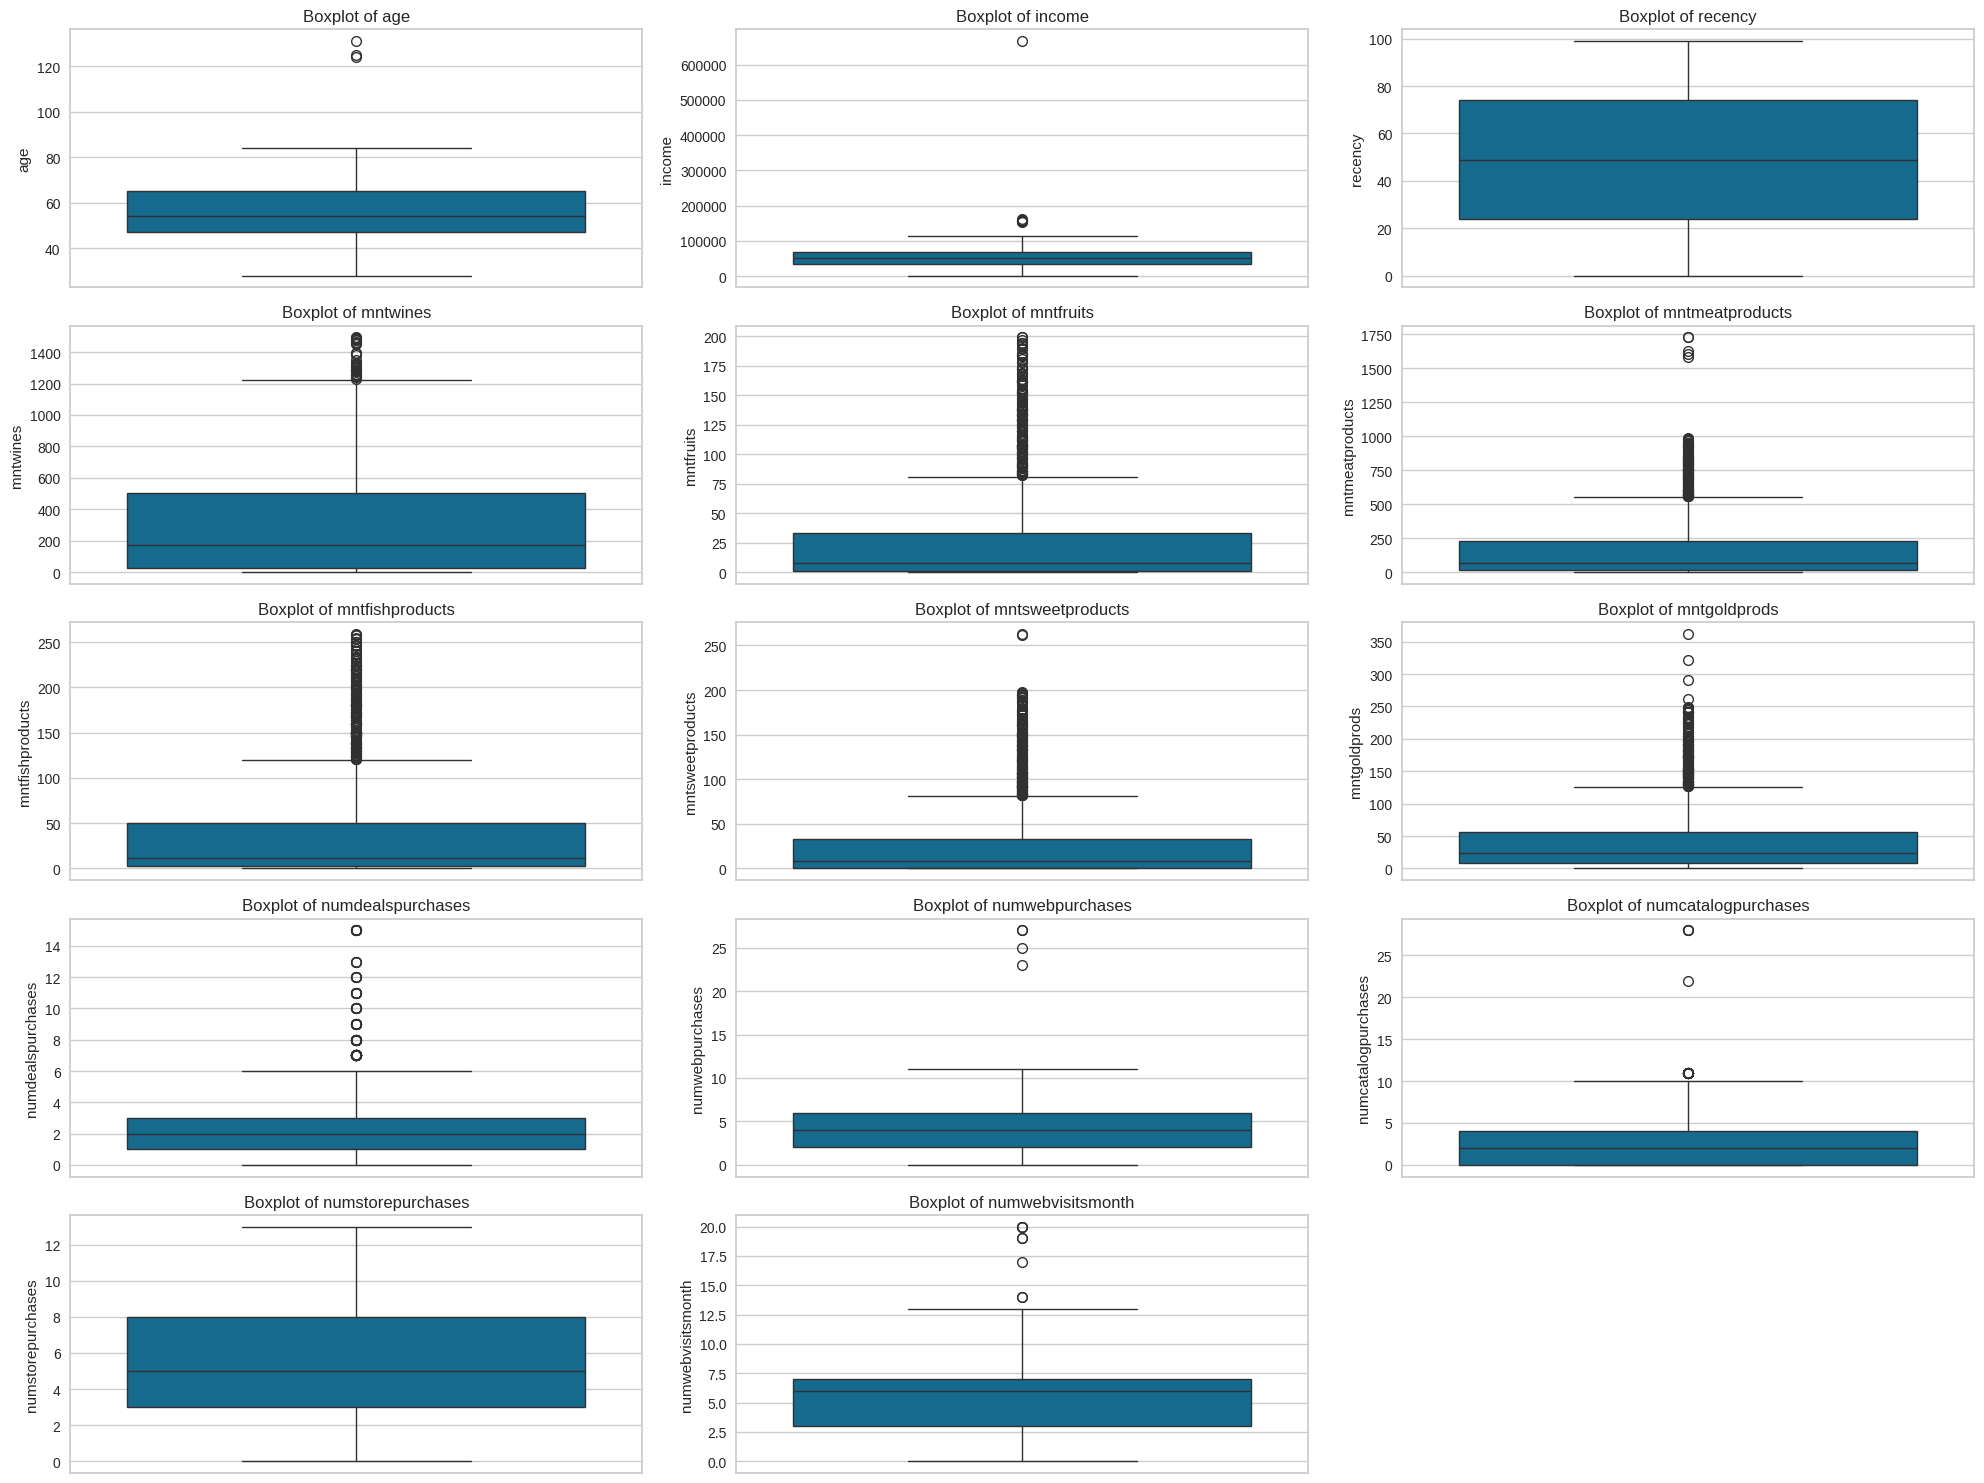

In [ ]:
###  detecting outlier with box plots
plot_columns = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
                    'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(figsize=(20, 15))

for index, column in enumerate(plot_columns):
    plt.subplot(5, 3, index + 1)  # Layout configuration 5x3 grid
    sns.boxplot(y=customer_df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()


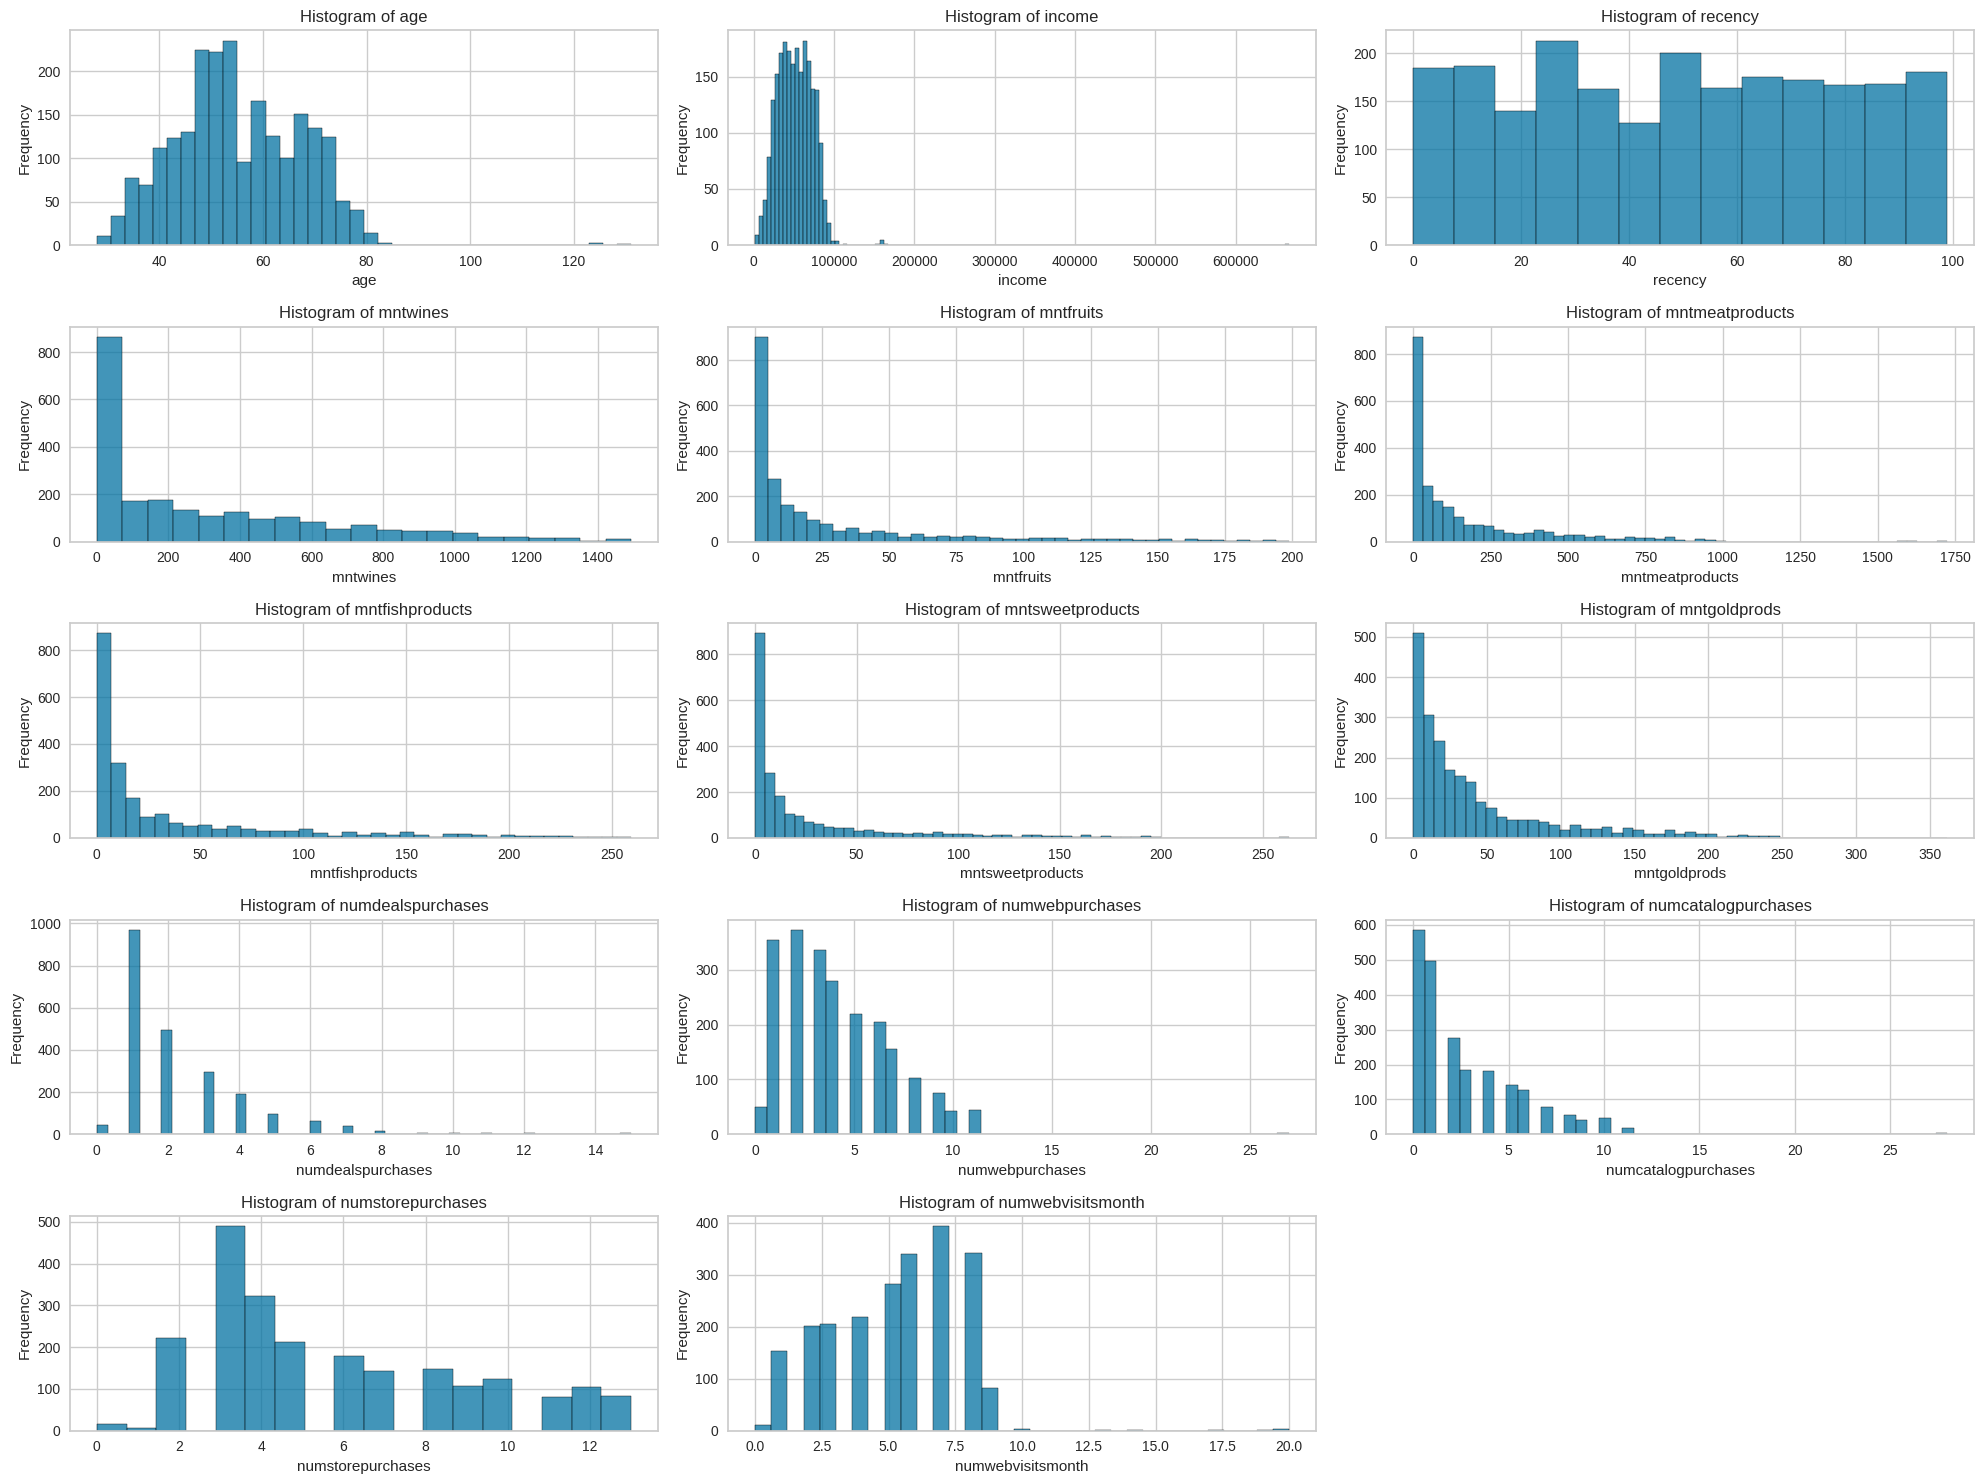

In [ ]:
###  detecting outliers with histograms
hist_columns = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
                'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(figsize=(20, 15))

for index, column in enumerate(hist_columns):
    plt.subplot(5, 3, index + 1)
    sns.histplot(customer_df[column], kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()


In [ ]:
###  checking normality with Tukey's method
features = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
            'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

for feature in features:
    q75, q25 = np.percentile(customer_df[feature], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1.5, 5.0, 0.5):
        min_val = q25 - (iqr * threshold)
        max_val = q75 + (iqr * threshold)

        outliersOne = customer_df[(customer_df[feature] > max_val) |
                               (customer_df[feature] < min_val)]

        print(f"Feature: {feature}")
        print(f"The score threshold is: {threshold}")
        print(f"Number of outliers is: {len(outliersOne)}")
        print(f"Outliers range: Below {min_val} and above {max_val}")


Feature: age
The score threshold is: 1.5
Number of outliers is: 3
Outliers range: Below 20.0 and above 92.0
Feature: age
The score threshold is: 2.0
Number of outliers is: 3
Outliers range: Below 11.0 and above 101.0
Feature: age
The score threshold is: 2.5
Number of outliers is: 3
Outliers range: Below 2.0 and above 110.0
Feature: age
The score threshold is: 3.0
Number of outliers is: 3
Outliers range: Below -7.0 and above 119.0
Feature: age
The score threshold is: 3.5
Number of outliers is: 1
Outliers range: Below -16.0 and above 128.0
Feature: age
The score threshold is: 4.0
Number of outliers is: 0
Outliers range: Below -25.0 and above 137.0
Feature: age
The score threshold is: 4.5
Number of outliers is: 0
Outliers range: Below -34.0 and above 146.0
Feature: income
The score threshold is: 1.5
Number of outliers is: 8
Outliers range: Below -13587.75 and above 117416.25
Feature: income
The score threshold is: 2.0
Number of outliers is: 8
Outliers range: Below -29963.25 and above 1337

In [ ]:
###  dropping rows with values that don't seem to be correct in age and income
customer_df = customer_df[customer_df['income'] < 600000]
customer_df = customer_df[customer_df['age'] < 100]


In [ ]:
###  applying box-cox transformation to imporve skewness and kurtosis
columns_to_transform = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
                        'mntgoldprods', 'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

for column in columns_to_transform:
    if any(customer_df[column] <= 0):
        customer_df[column] += (1 - customer_df[column].min())
    transformed_data, fitted_lambda = stats.boxcox(customer_df[column])
    customer_df[column] = transformed_data

    print(f'Applied Box-Cox to {column} with lambda: {fitted_lambda}')


Applied Box-Cox to age with lambda: 0.6760556225181878
Applied Box-Cox to income with lambda: 0.7218834715786238
Applied Box-Cox to recency with lambda: 0.7146869025547244
Applied Box-Cox to mntwines with lambda: 0.189943903591169
Applied Box-Cox to mntfruits with lambda: -0.03186999666801054
Applied Box-Cox to mntmeatproducts with lambda: 0.03074233287512811
Applied Box-Cox to mntfishproducts with lambda: 0.018298766365053624
Applied Box-Cox to mntsweetproducts with lambda: -0.032230227717008626
Applied Box-Cox to mntgoldprods with lambda: 0.11420019164588437
Applied Box-Cox to numdealspurchases with lambda: -0.48610620445732294
Applied Box-Cox to numwebpurchases with lambda: 0.19065488549819928
Applied Box-Cox to numcatalogpurchases with lambda: -0.10178101313701893
Applied Box-Cox to numstorepurchases with lambda: 0.11028866816461147
Applied Box-Cox to numwebvisitsmonth with lambda: 0.8645879642126717


In [ ]:
###  as we can see the number of outliers decreased after box-cox transformation
features = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
            'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

for feature in features:
    q75, q25 = np.percentile(customer_df[feature], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1.5, 5.0, 0.5):
        min_val = q25 - (iqr * threshold)
        max_val = q75 + (iqr * threshold)

        outliersTwo = customer_df[(customer_df[feature] > max_val) |
                               (customer_df[feature] < min_val)]

        print(f"Feature: {feature}")
        print(f"The score threshold is: {threshold}")
        print(f"Number of outliers is: {len(outliersTwo)}")
        print(f"Outliers range: Below {min_val} and above {max_val}")

Feature: age
The score threshold is: 1.5
Number of outliers is: 0
Outliers range: Below 11.151356221769063 and above 30.731956604789715
Feature: age
The score threshold is: 2.0
Number of outliers is: 0
Outliers range: Below 8.703781173891482 and above 33.17953165266729
Feature: age
The score threshold is: 2.5
Number of outliers is: 0
Outliers range: Below 6.2562061260139 and above 35.62710670054488
Feature: age
The score threshold is: 3.0
Number of outliers is: 0
Outliers range: Below 3.808631078136319 and above 38.074681748422464
Feature: age
The score threshold is: 3.5
Number of outliers is: 0
Outliers range: Below 1.3610560302587373 and above 40.52225679630004
Feature: age
The score threshold is: 4.0
Number of outliers is: 0
Outliers range: Below -1.0865190176188442 and above 42.96983184417762
Feature: age
The score threshold is: 4.5
Number of outliers is: 0
Outliers range: Below -3.5340940654964257 and above 45.417406892055205
Feature: income
The score threshold is: 1.5
Number of o

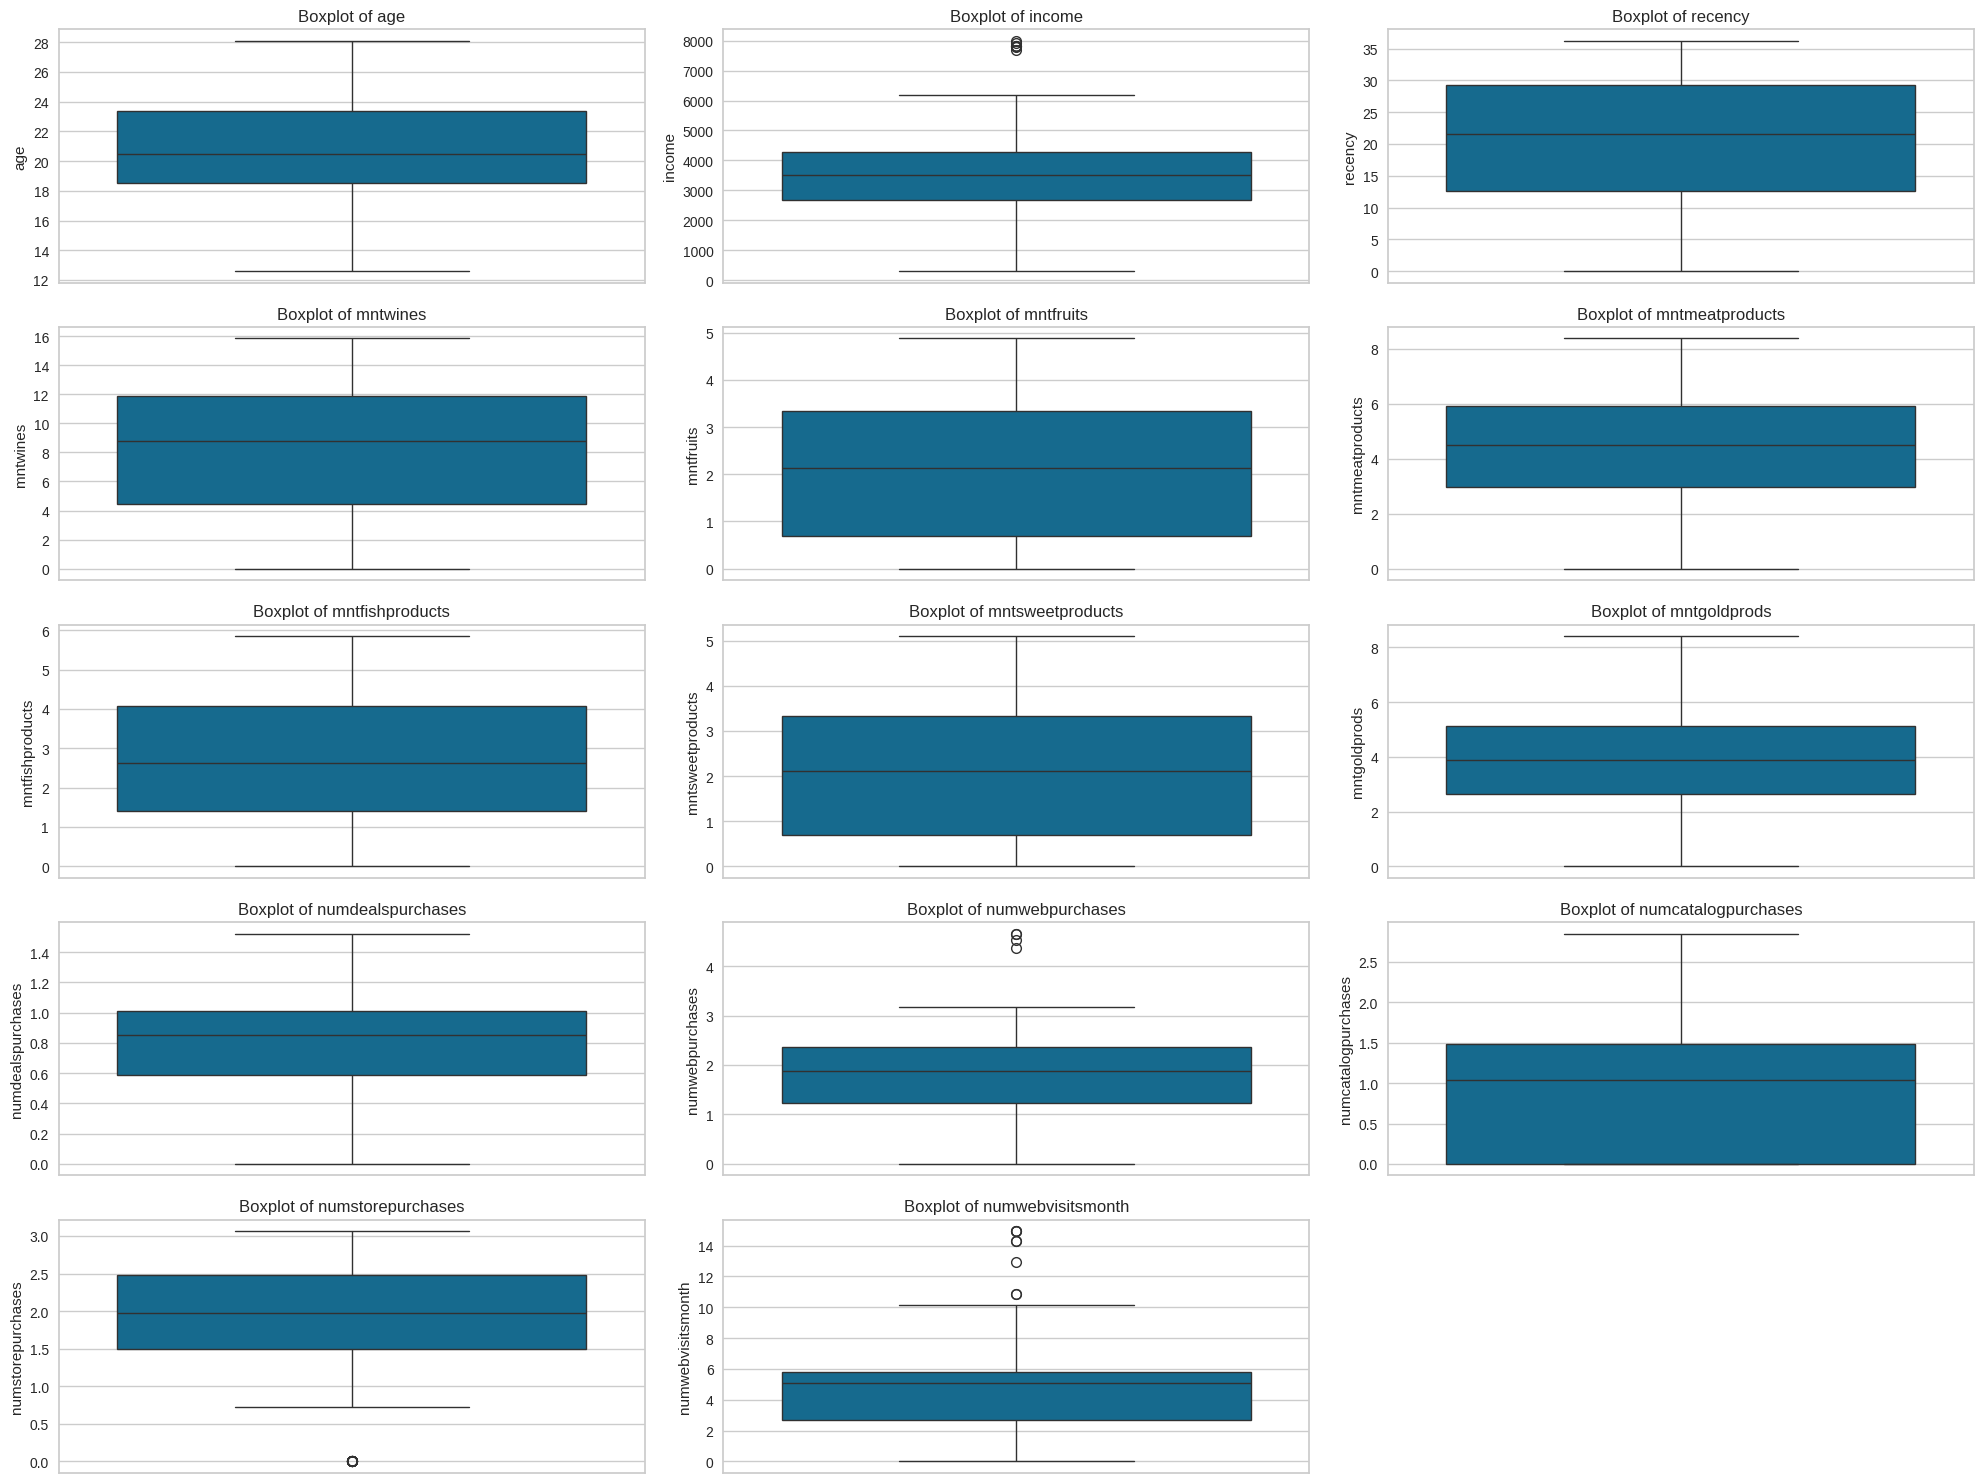

In [ ]:
###  comparing results after box-cox transformation, we can see imporvements
plot_columns = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
                    'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(figsize=(20, 15))

for index, column in enumerate(plot_columns):
    plt.subplot(5, 3, index + 1)  # Layout configuration 5x3 grid
    sns.boxplot(y=customer_df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

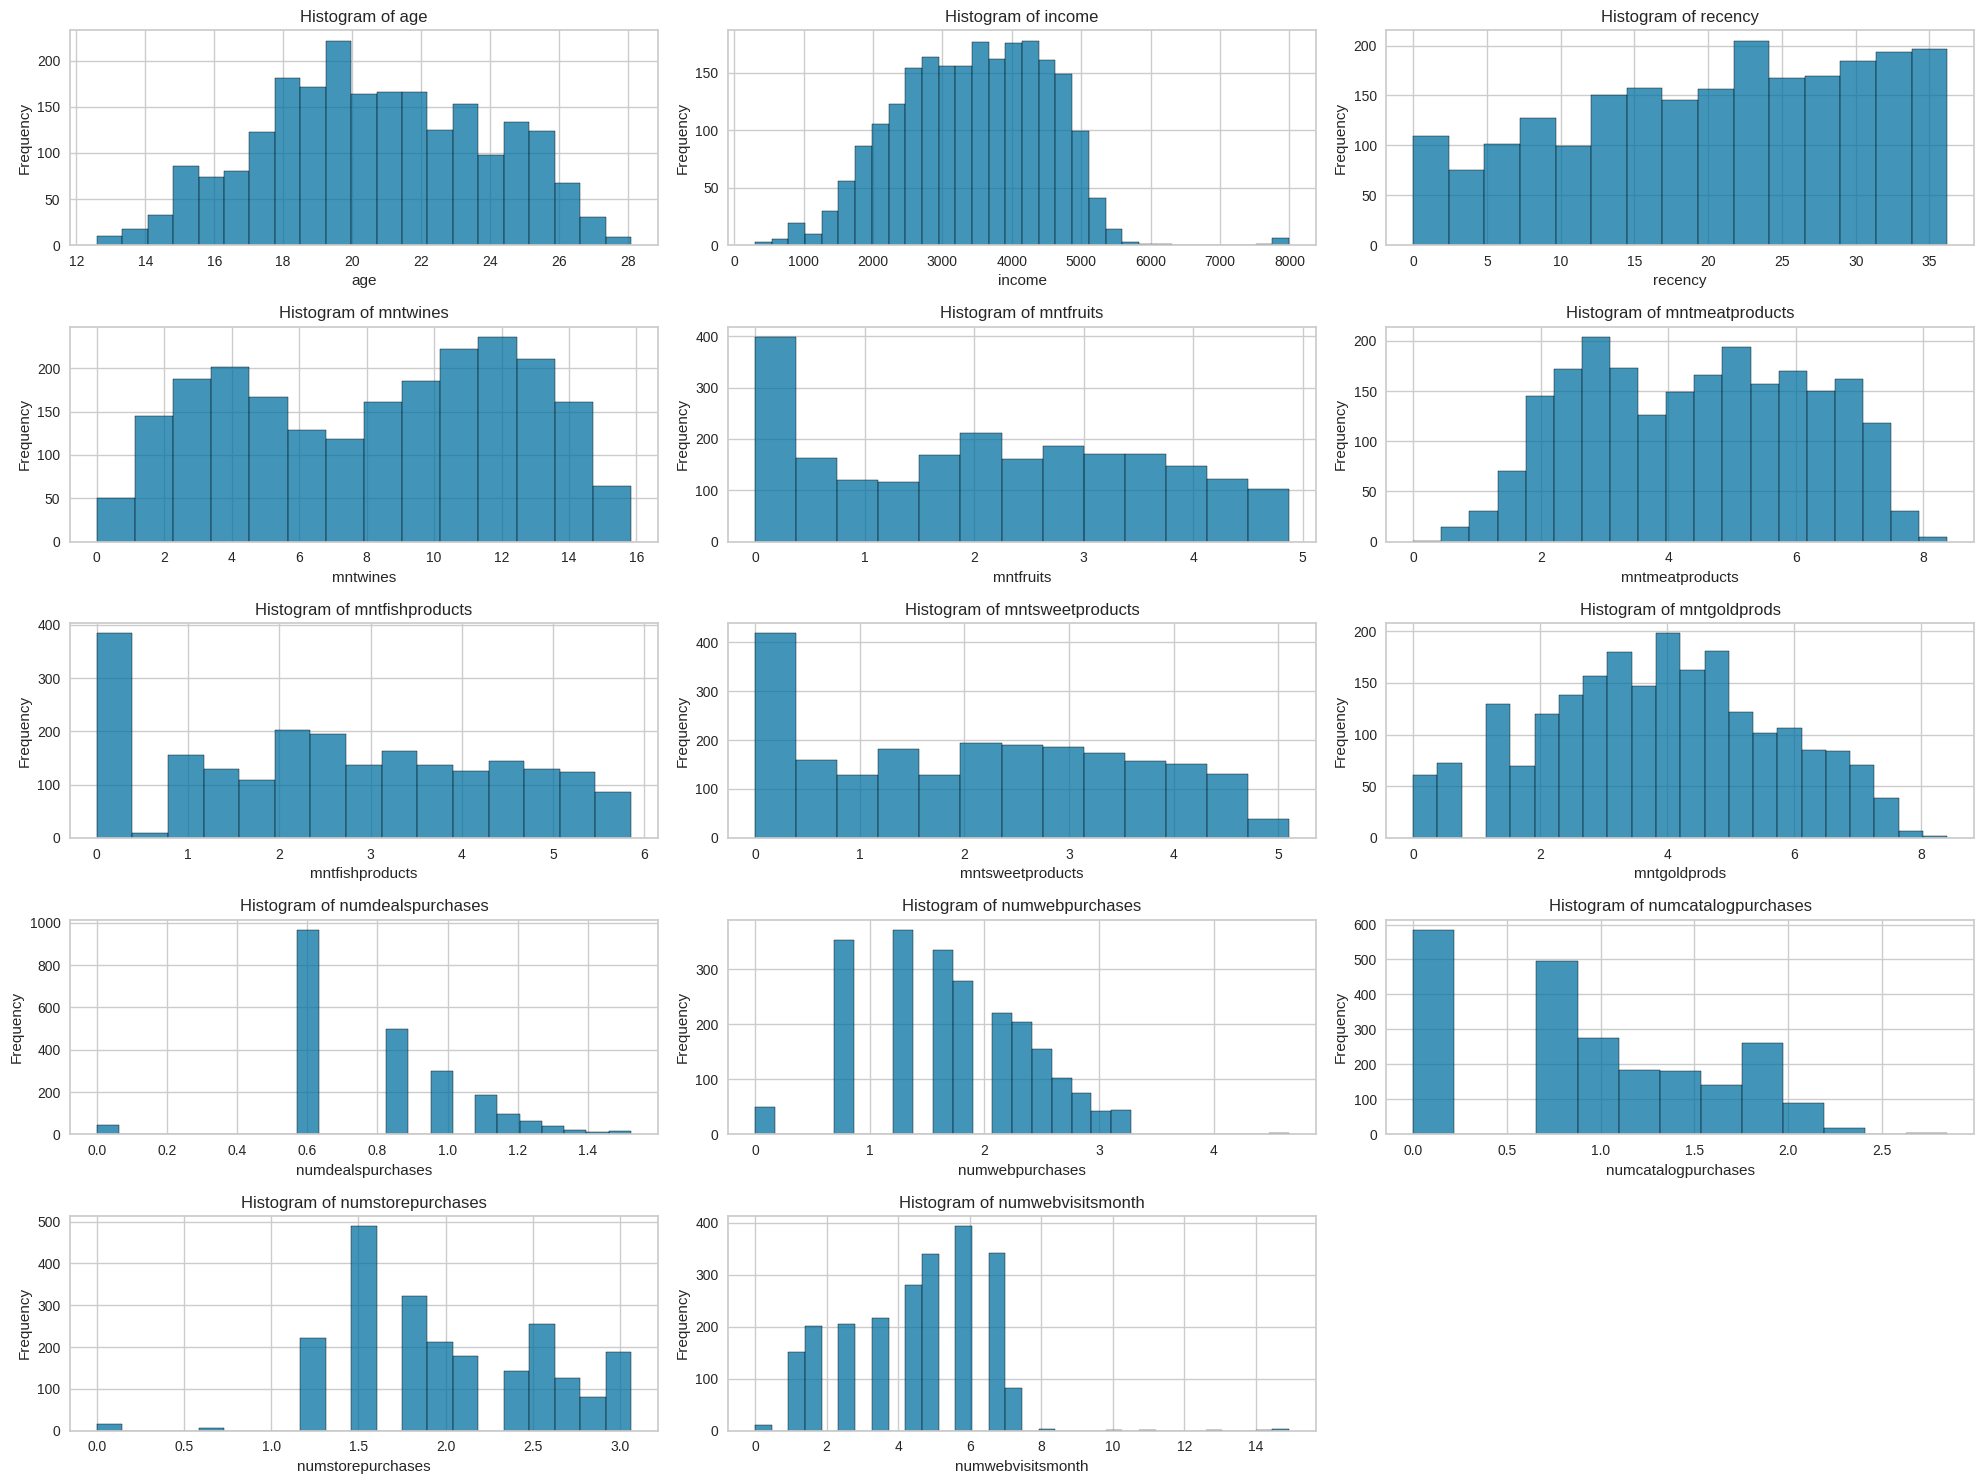

In [ ]:
hist_columns = ['age', 'income', 'recency', 'mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods',
                'numdealspurchases', 'numwebpurchases', 'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth']

plt.figure(figsize=(20, 15))

for index, column in enumerate(hist_columns):
    plt.subplot(5, 3, index + 1)
    sns.histplot(customer_df[column], kde=False)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()

# Data Exploration: Overview

In [ ]:
# ###  after Box-Cox transformation of continuous variables we see that they are still skewed but closer to being normal
# #!pip install dataprep
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing
# plot(customer_df)

# Feature Engineering

In [ ]:
###  creating a new feature 'total_spending' that is the total amount the customer spent on all products within the period
customer_df['total_spend'] = customer_df['mntwines'] + customer_df['mntfruits'] + customer_df['mntmeatproducts'] + customer_df['mntfishproducts'] + customer_df['mntsweetproducts'] + customer_df['mntgoldprods']

###  renaming features for ease of use
customer_df = customer_df.rename(columns={'numwebpurchases': 'web', 'numcatalogpurchases': 'catalog', 'numstorepurchases': 'store', 'numwebvisitsmonth': 'webvisits',
                                          'numdealspurchases': 'deals', 'mntwines': 'wines', 'mntfruits': 'fruits', 'mntmeatproducts': 'meats', 'mntfishproducts': 'fish',
                                          'mntsweetproducts': 'sweets', 'mntgoldprods': 'gold', 'response': 'acceptedlast'})

###  since all of the respondents in education have some level of education, i will split this feature into undergrad and postgrad
customer_df['education'] = customer_df['education'].replace({'basic':'undergrad', '2n cycle':'undergrad', 'graduation':'postgrad', 'master':'postgrad', 'phd':'postgrad'})

###  splitting 'marital_status' into two categories anole or in couple
customer_df['marital_status'] = customer_df['marital_status'].replace({'divorced':'alone', 'single':'alone', 'married':'in couple', 'together':'in couple',
                                                                       'absurd':'alone', 'widow':'alone', 'yolo':'alone'})

###  creating new feature 'has_child' indicating if the customer has a child and 'num_children' indicating the number to use in visualization
customer_df['num_children'] = customer_df['kidhome'] + customer_df['teenhome']
customer_df['has_child'] = np.where(customer_df.num_children > 0, 'has child', 'no child')
customer_df['num_children'] = customer_df['num_children'].replace({3: "3 children", 2:'2 children', 1:'1 child', 0:"no child"}, inplace=True)


In [ ]:
customer_df.info()
customer_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2236 entries, 0 to 2239
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2236 non-null   int64  
 1   age              2236 non-null   float64
 2   education        2236 non-null   object 
 3   marital_status   2236 non-null   object 
 4   income           2236 non-null   float64
 5   kidhome          2236 non-null   int64  
 6   teenhome         2236 non-null   int64  
 7   recency          2236 non-null   float64
 8   wines            2236 non-null   float64
 9   fruits           2236 non-null   float64
 10  meats            2236 non-null   float64
 11  fish             2236 non-null   float64
 12  sweets           2236 non-null   float64
 13  gold             2236 non-null   float64
 14  deals            2236 non-null   float64
 15  web              2236 non-null   float64
 16  catalog          2236 non-null   float64
 17  store            22

id        age education marital_status       income  kidhome  teenhome  \
0  5524  23.903993  postgrad          alone  3808.552574        0         0   
1  2174  24.666905  postgrad          alone  3233.333285        1         1   
2  4141  21.813113  postgrad      in couple  4427.263986        0         0   
3  6182  16.430982  postgrad      in couple  2167.934189        1         0   
4  5324  17.328420  postgrad      in couple  3815.882435        1         0   

     recency      wines    fruits  ...  acceptedcmp1  acceptedcmp2  complain  \
0  24.393017  12.677427  4.182357  ...             0             0         0   
1  17.787350   3.175600  0.685547  ...             0             0         0   
2  13.353133  11.369735  3.677982  ...             0             0         0   
3  13.353133   3.175600  1.568858  ...             0             0         0   
4  34.853234   8.761917  3.564902  ...             0             0         0   

   z_costcontact  z_revenue  acceptedlast  months_enrolled  total_spend  \
0              3         11             1              144    39.263448   
1              3         11             0              117     9.840702   
2              3         11             0              128    32.848750   
3              3         11             0              115    13.731315   
4              3         11             0              123    27.885159   

   num_children  has_child  
0          None   no child  
1          None  has child  
2          None   no child  
3          None  has child  
4          None  has child  

[5 rows x 32 columns]

# Data Exploration: Multivariate Analysis

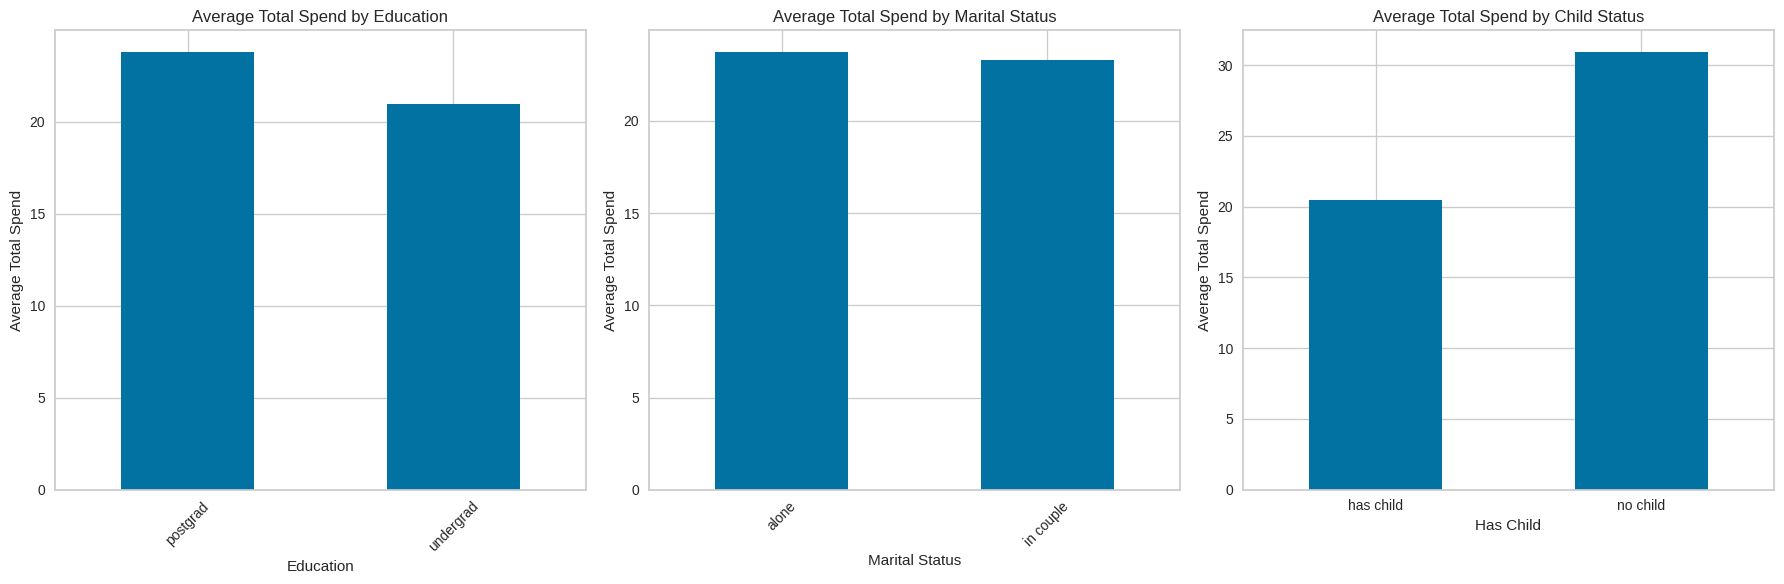

In [ ]:
###  postgrad customers that have no children and live alone tend to spend slightly more overall
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

customer_df.groupby('education')['total_spend'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Average Total Spend by Education')
axes[0].set_xlabel('Education')
axes[0].set_ylabel('Average Total Spend')
axes[0].tick_params(axis='x', rotation=45)

customer_df.groupby('marital_status')['total_spend'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Total Spend by Marital Status')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Average Total Spend')
axes[1].tick_params(axis='x', rotation=45)

customer_df.groupby('has_child')['total_spend'].mean().plot(kind='bar', ax=axes[2])
axes[2].set_title('Average Total Spend by Child Status')
axes[2].set_xlabel('Has Child')
axes[2].set_ylabel('Average Total Spend')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


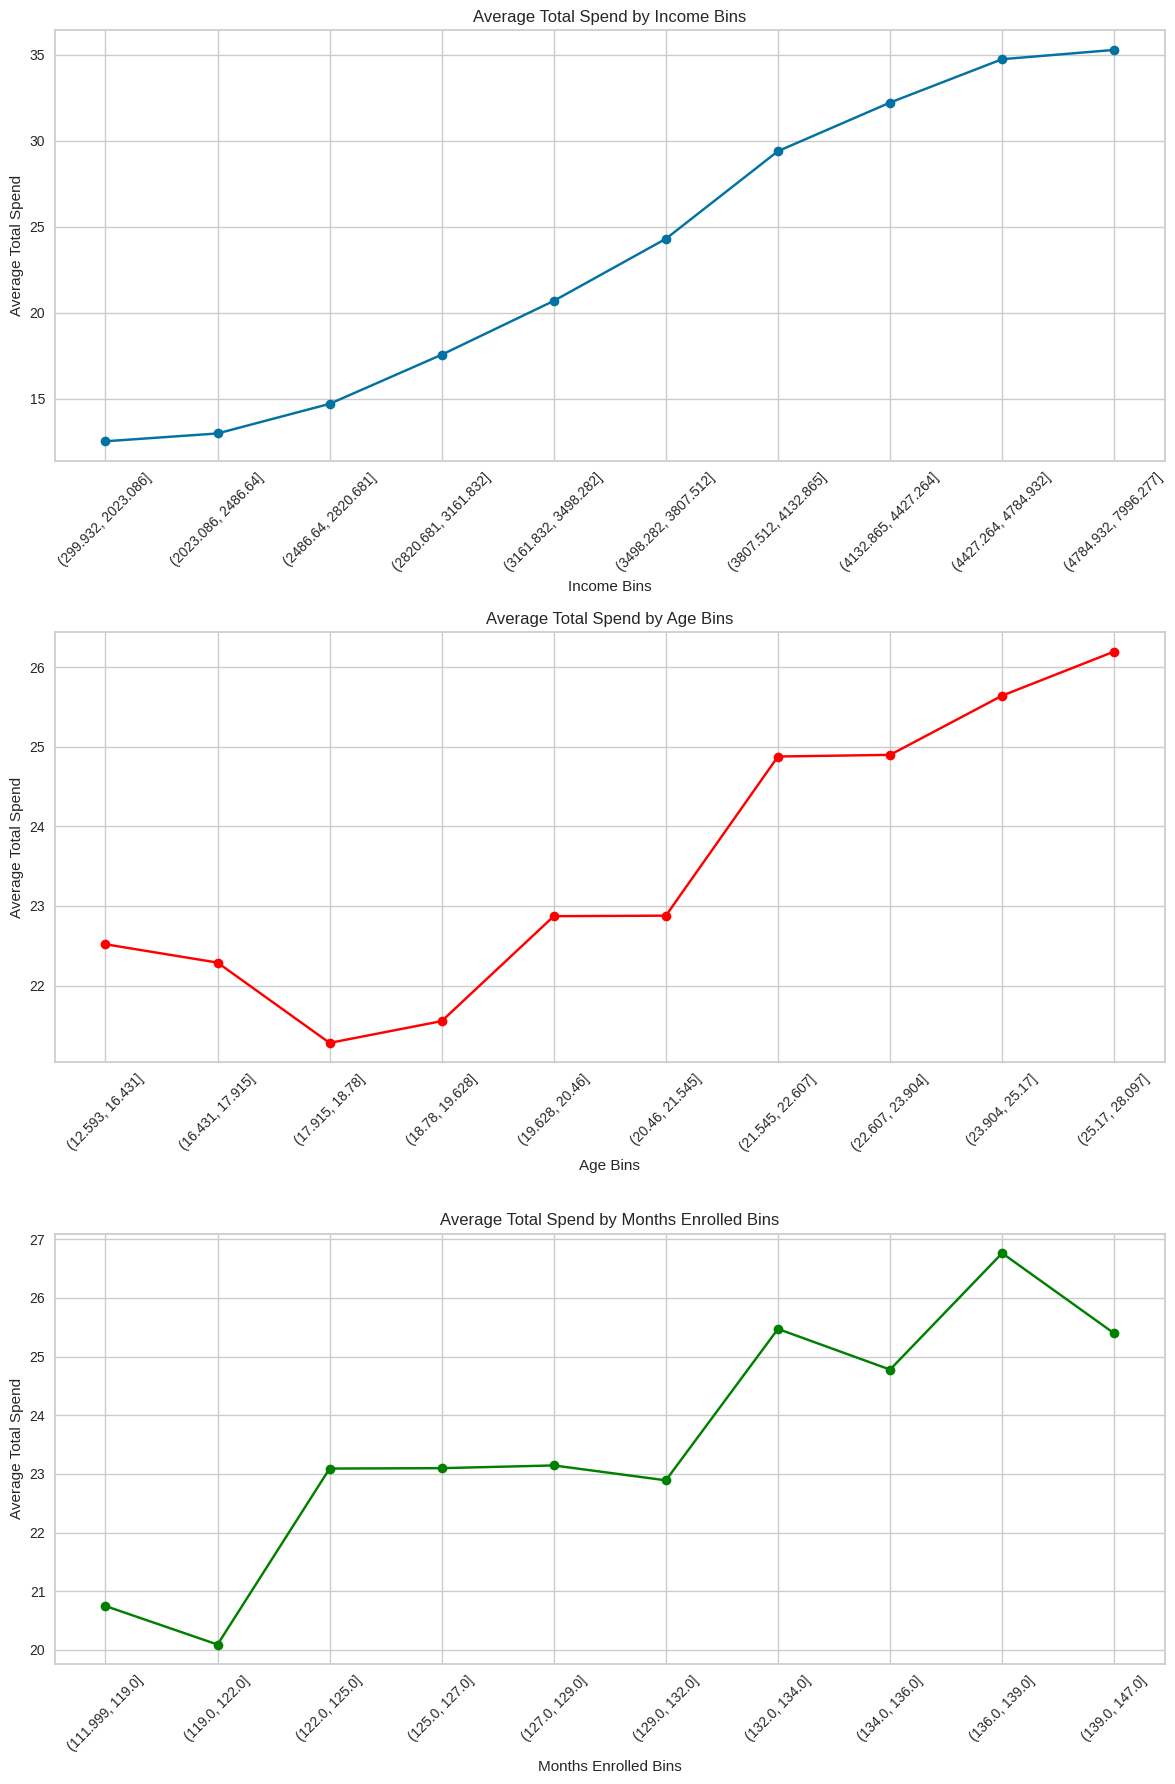

In [ ]:
###  the subplots of 'total_spend' with 'age', 'income' and months_enrolled all show positive correlation
customer_df['Income Bin'] = pd.qcut(customer_df['income'], q=10, duplicates='drop')
customer_df['Age Bin'] = pd.qcut(customer_df['age'], q=10, duplicates='drop')
customer_df['Months Enrolled Bin'] = pd.qcut(customer_df['months_enrolled'], q=10, duplicates='drop')

income_data = customer_df.groupby('Income Bin')['total_spend'].mean().reset_index()
age_data = customer_df.groupby('Age Bin')['total_spend'].mean().reset_index()
months_enrolled_data = customer_df.groupby('Months Enrolled Bin')['total_spend'].mean().reset_index()

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].plot(income_data['Income Bin'].astype(str), income_data['total_spend'], marker='o')
axs[0].set_title('Average Total Spend by Income Bins')
axs[0].set_xlabel('Income Bins')
axs[0].set_ylabel('Average Total Spend')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

axs[1].plot(age_data['Age Bin'].astype(str), age_data['total_spend'], marker='o', color='red')
axs[1].set_title('Average Total Spend by Age Bins')
axs[1].set_xlabel('Age Bins')
axs[1].set_ylabel('Average Total Spend')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

axs[2].plot(months_enrolled_data['Months Enrolled Bin'].astype(str), months_enrolled_data['total_spend'], marker='o', color='green')
axs[2].set_title('Average Total Spend by Months Enrolled Bins')
axs[2].set_xlabel('Months Enrolled Bins')
axs[2].set_ylabel('Average Total Spend')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


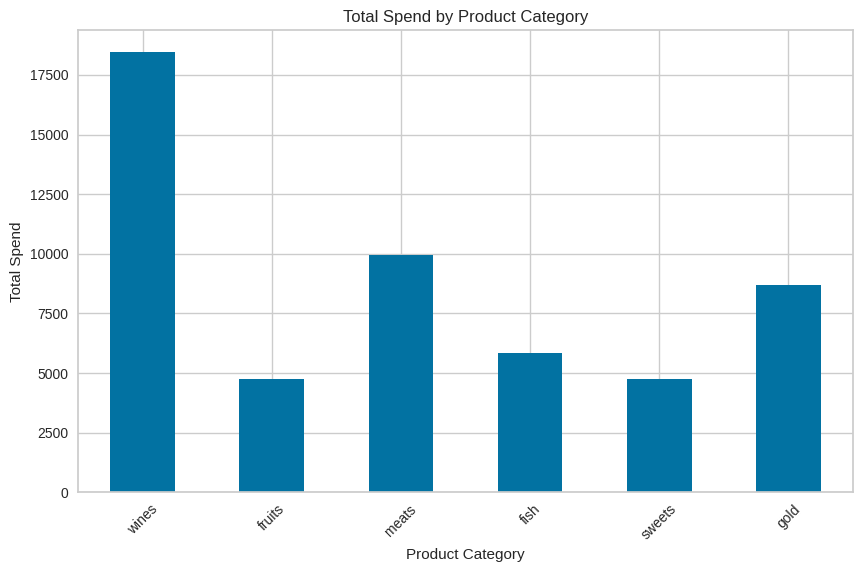

In [ ]:
###  total spend in each category. Wine is the best seller, over 70% more that the next best seller meats
category_totals = customer_df[['wines', 'fruits', 'meats', 'fish', 'sweets', 'gold']].sum()

plt.figure(figsize=(10, 6))
category_totals.plot(kind='bar')
plt.title('Total Spend by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)

plt.show()


# Data Exploration: Bivariate Analysis

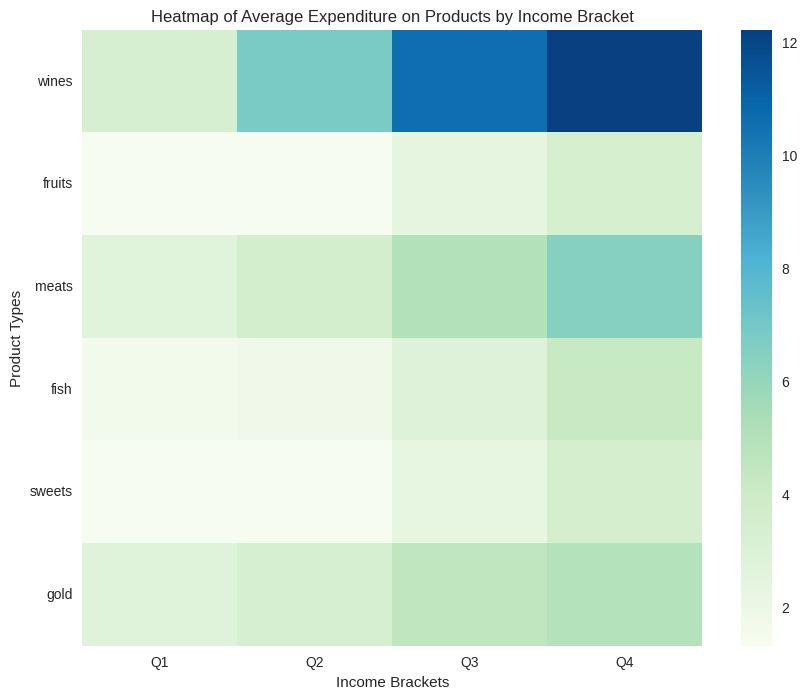

Q1 (25th percentile): 2667.252179819702
Q2 (50th percentile): 3498.282047189772
Q3 (75th percentile): 4277.296344649688
IQR (Interquartile Range): 1610.0441648299857
Total wine spend for Q3 and Q4 income brackets: 12767.731237181903
income bracket
Q1    559
Q2    559
Q3    559
Q4    559
Name: count, dtype: int64


In [ ]:
###  the heatmap reflects income and the amount spent in product categories. Higher income seems to be directly correlated with amount spent in genral, but especially so
#    in wine category and in meats a little weaker. In wine category total sale is about $18000 from which $12700 was made by customers in q3 and q4 with $3500 or more
#    monthly income. This is a useful information for targeting customers in this inome brackets either by advertisemtnt of adding more variety similar to wines they buy.
#    The heatmap also suggests that customers in q3 and q4 also spend big on meats. Increasing freshness and variety of meats can in turn boost more wine sells and vice versa.
product_data = customer_df[['income', 'wines', 'fruits', 'meats', 'fish', 'sweets', 'gold']]
product_data['income bracket'] = pd.qcut(product_data['income'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
product_data = product_data.drop('income', axis=1)
grouped_data = product_data.groupby('income bracket').mean()
heatmap_data = grouped_data.transpose()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap="GnBu")

plt.xlabel('Income Brackets')
plt.ylabel('Product Types')
plt.title('Heatmap of Average Expenditure on Products by Income Bracket')
plt.yticks(rotation=0)  # This ensures that the product labels are not rotated
plt.show()

# Calculate the quartiles
Q1 = customer_df['income'].quantile(0.25)
Q2 = customer_df['income'].quantile(0.50)
Q3 = customer_df['income'].quantile(0.75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (50th percentile): {Q2}")
print(f"Q3 (75th percentile): {Q3}")

IQR = Q3 - Q1
print(f"IQR (Interquartile Range): {IQR}")

high_income_wine_spend = product_data[product_data['income bracket'].isin(['Q3', 'Q4'])]['wines'].sum()
print(f"Total wine spend for Q3 and Q4 income brackets: {high_income_wine_spend}")

count = product_data['income bracket'].value_counts().sort_index()
print(count)


# Feature Selection: Preparing Final Dataset

In [ ]:
###  standardizing continuous features and preparing the final dataset
standardized_df = customer_df[['income', 'total_spend', 'months_enrolled']]
scaler = StandardScaler()
df_std = scaler.fit_transform(standardized_df)
df_std = pd.DataFrame(df_std, columns=standardized_df.columns)
df_std = df_std.dropna()


# Clustering

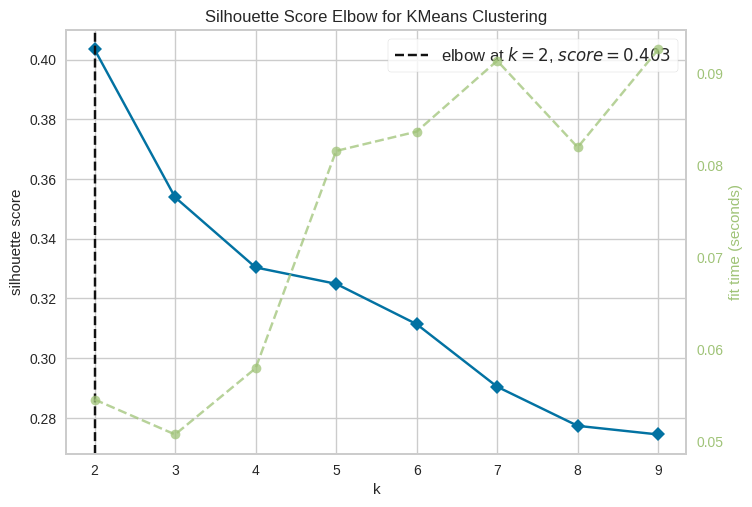

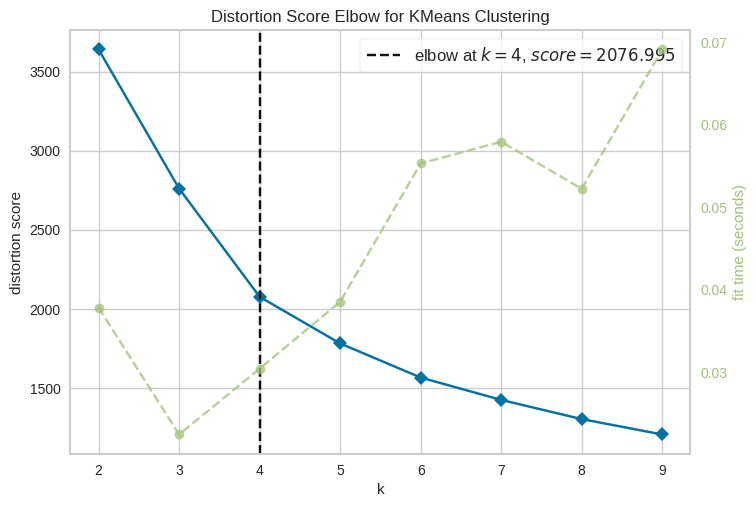

In [ ]:
###  both Silhouette and Distortion Screeplots suggest 4 to 6 clusters are optimal. After trying with all three, 5 clusters showed best results.
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric = 'silhouette')
visualizer.fit(df_std)
visualizer.show()
plt.show()

model = KMeans(random_state=22)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(df_std)
visualizer.show()
plt.show()


# K-MEANS

In [ ]:
###  running the kmeans with 5 clusters and doing cross validation. The cross validation with different random states shows
#    Adjusted Rand Index of 1.0 whcih is an excellent result confirming stability of the clusters
optimal_k = 5
random_states = np.random.randint(0, 1000, size=10)
cluster_labels_all = []

for state in random_states:
    kmeans = KMeans(n_clusters=optimal_k, random_state=state)
    kmeans.fit(df_std)
    cluster_labels = kmeans.labels_
    cluster_labels_all.append(cluster_labels)

ari_scores = []
for i in range(len(cluster_labels_all)):
    for j in range(i + 1, len(cluster_labels_all)):
        ari = adjusted_rand_score(cluster_labels_all[i], cluster_labels_all[j])
        ari_scores.append(ari)

average_ari = np.mean(ari_scores)
print(f"Stability Check: Average ARI over 10 runs is {average_ari:.3f}, indicating highly consistent clustering.")

df_std['cluster_labels'] = cluster_labels_all[0]
cluster_groups = df_std.groupby('cluster_labels')
for cluster, group in cluster_groups:
    print(f"Cluster {cluster} Summary:")
    print(group.describe().transpose())


Stability Check: Average ARI over 10 runs is 0.923, indicating highly consistent clustering.
Cluster 0 Summary:
                 count      mean       std       min       25%       50%  \
income           454.0  0.897799  0.505846 -0.180956  0.561348  0.869596   
total_spend      454.0  1.062757  0.366634 -0.951508  0.828107  1.100070   
months_enrolled  454.0  0.920046  0.552567 -0.033048  0.493837  0.889001   
cluster_labels   454.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                      75%       max  
income           1.220496  4.279766  
total_spend      1.327703  1.872410  
months_enrolled  1.284165  2.337936  
cluster_labels   0.000000  0.000000  
Cluster 1 Summary:
                 count      mean       std       min       25%       50%  \
income           489.0 -0.724689  0.619972 -2.960966 -1.115639 -0.694064   
total_spend      489.0 -1.058914  0.425151 -1.954991 -1.355071 -1.094644   
months_enrolled  489.0 -0.997119  0.528847 -2.272311 -1.350262 -0.9550

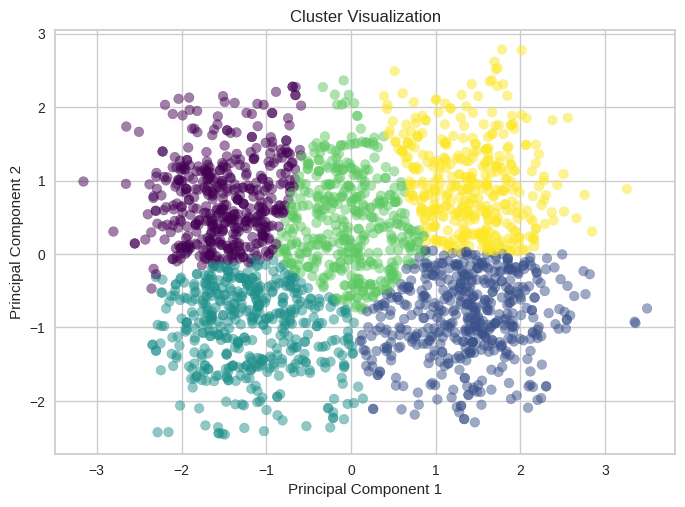

In [ ]:
###  quick visualization with PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_std.drop('cluster_labels', axis=1))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df_std['cluster_labels'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.show()


The average silhouette score for 5 clusters is: 0.519


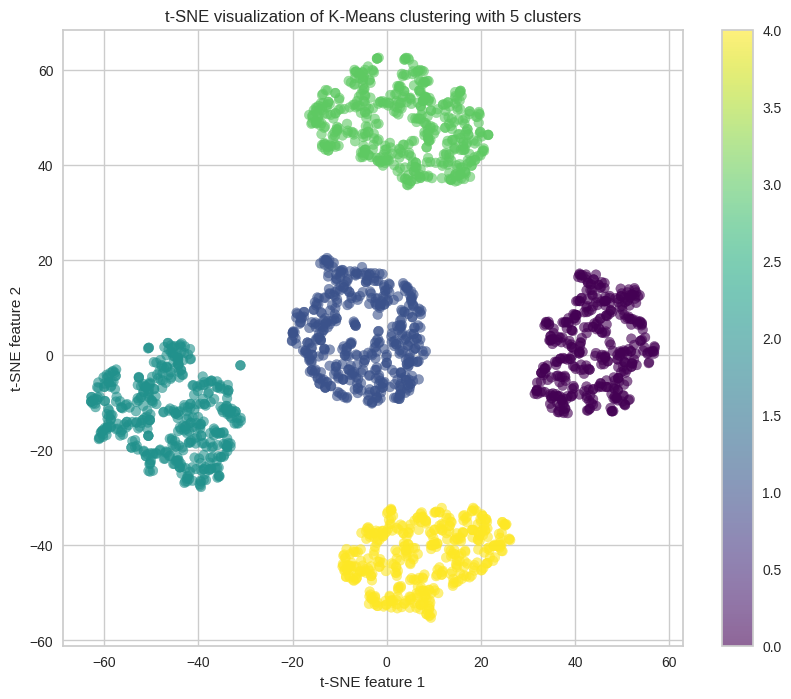

In [ ]:
###  K-MEANS with t-SNE visualization
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=20, max_iter=2000, tol=1e-4, random_state=22, algorithm='auto')
cluster_labels = kmeans_final.fit_predict(df_std)

silhouette_avg = silhouette_score(df_std, cluster_labels)
print(f"The average silhouette score for {optimal_k} clusters is: {silhouette_avg:.3f}")

tsne = TSNE(n_components=2, random_state=22)
tsne_results = tsne.fit_transform(df_std)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of K-Means clustering with 5 clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

###  selected the best performing parameters


# Gaussian Mixture

In [ ]:
X = df_std.drop('cluster_labels', axis=1)
norm = normalize(X, norm='l2')
gauss_df = pd.DataFrame(norm, columns=X.columns)

gmm_cluster = GaussianMixture(n_components=2, covariance_type='full', max_iter=2000, tol=1e-3, random_state=123)
new_labels = gmm_cluster.fit_predict(norm)
gauss_df['predicted_cluster'] = new_labels

score = silhouette_score(norm, new_labels)
print("Silhouette Score: {:.3f}".format(score))

###  at it's optimal, the model produces 2 components, covariance type: full or spherical, tol: up to 5


Silhouette Score: 0.459


# Agglomerative

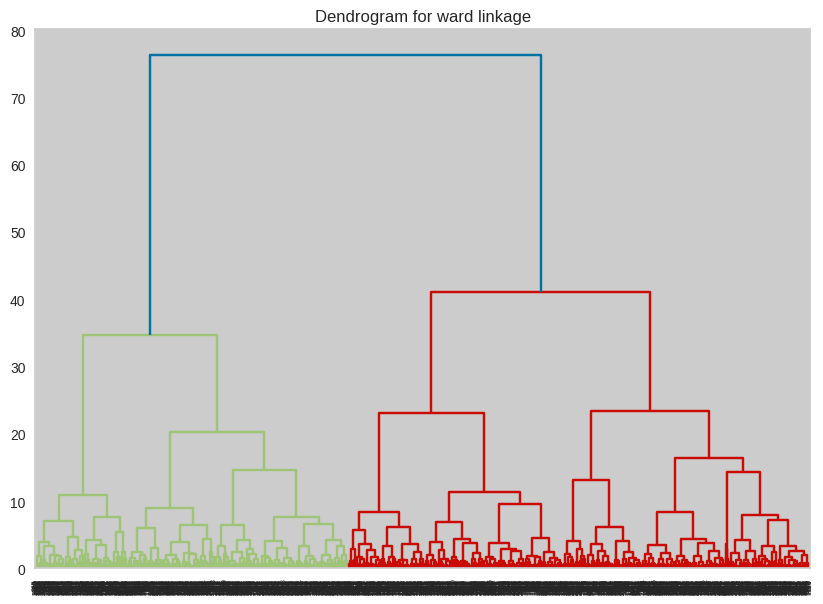

Linkage method: ward
Silhouette score: 0.3850
------------------------------------------------


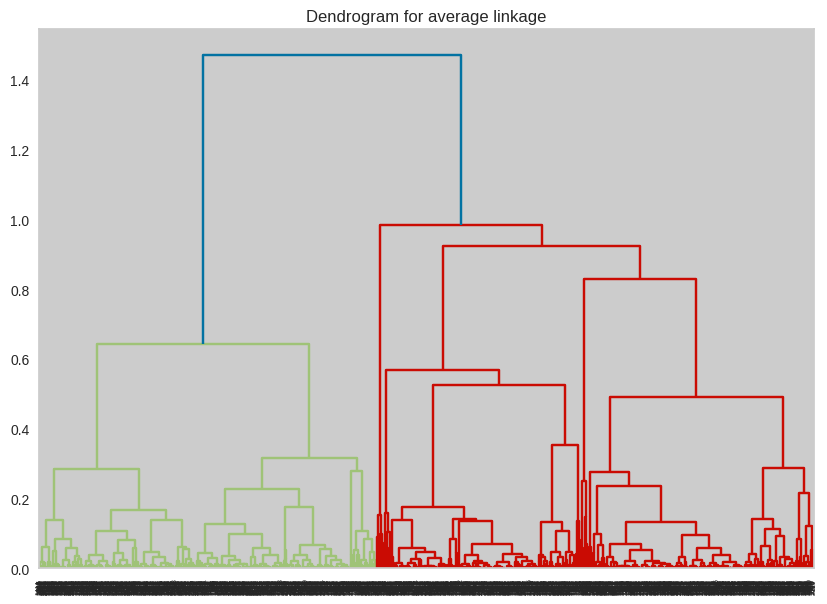

Linkage method: average
Silhouette score: 0.3953
------------------------------------------------


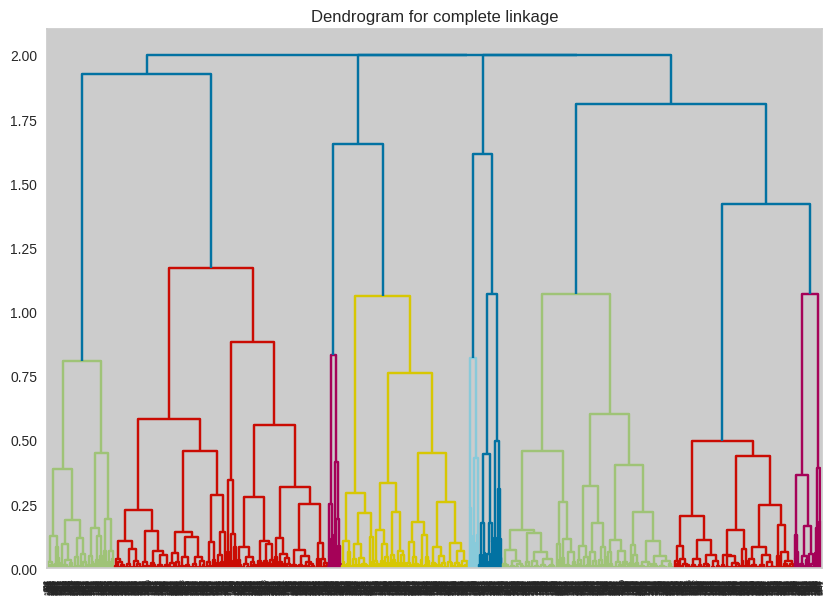

Linkage method: complete
Silhouette score: 0.2850
------------------------------------------------
All results:
Linkage method: ward, Silhouette score: 0.3850
Linkage method: average, Silhouette score: 0.3953
Linkage method: complete, Silhouette score: 0.2850


In [ ]:
Z = df_std.drop('cluster_labels', axis=1)
linkage_methods = ["ward", "average", "complete"]
affinities = {"ward": "euclidean", "average": "cosine", "complete": "cosine"}

results = []
for method in linkage_methods:
    affinity = affinities[method]
    agg_cluster = AgglomerativeClustering(
        n_clusters = 2,
        linkage = method,
        affinity = affinity
    )

    clusters = agg_cluster.fit_predict(Z)
    silhouette = silhouette_score(Z, clusters, metric='euclidean')
    results.append((method, silhouette))

    linked = linkage(Z, method=method, metric=affinity)
    plt.figure(figsize=(10, 7))
    plt.title(f"Dendrogram for {method} linkage")
    dendrogram(linked)
    plt.show()

    print(f"Linkage method: {method}")
    print(f"Silhouette score: {silhouette:.4f}")
    print("------------------------------------------------")

print("All results:")
for result in results:
    print(f"Linkage method: {result[0]}, Silhouette score: {result[1]:.4f}")

###  linkage methos 'average' performs best among the three with silhouette score of 0.39. I also tried the algorithm with different number of clusters.
#    two cluster solution is the highest ranking.


# WILL PROCEED WITH KMEANS MODEL
*  KMEANS model average silhouette score for 5 clusters: 0.535
*  Gaussian Mixture model average Silhouette Score: 0.459
*  Agglomerative model with linkage method Average Silhouette score: 0.3943


# Further Analysis with Labels

In [ ]:
###  preping dataset with cluster labels for final alanlysis. I renamed the labels based on descriptive statistics.
labels_df = pd.DataFrame(cluster_labels, columns=['cluster_labels'])
customer_df_with_labels = pd.concat([customer_df_clean, labels_df], axis=1)

customer_df_with_labels['total_spend'] = customer_df_with_labels['mntwines'] + customer_df_with_labels['mntfruits'] + customer_df_with_labels['mntmeatproducts'] + customer_df_with_labels['mntfishproducts'] + customer_df_with_labels['mntsweetproducts'] + customer_df_with_labels['mntgoldprods']
customer_df_with_labels = customer_df_with_labels.rename(columns={'numwebpurchases': 'web', 'numcatalogpurchases': 'catalog', 'numstorepurchases': 'store',
                                                                  'numwebvisitsmonth': 'webvisits','numdealspurchases': 'deals', 'mntwines': 'wines', 'mntfruits': 'fruits',
                                                                  'mntmeatproducts': 'meats', 'mntfishproducts': 'fish','mntsweetproducts': 'sweets', 'mntgoldprods': 'gold', 'response': 'acceptedlast'})
customer_df_with_labels['cluster_labels'].replace({0:"Average Spenders", 1:'Highest Spenders', 2:'Lowest Spenders', 3:'High Spenders', 4:'Consistent Patrons'},inplace=True)
customer_df_with_labels['education'] = customer_df_with_labels['education'].replace({'basic':'undergrad', '2n cycle':'undergrad', 'graduation':'postgrad', 'master':'postgrad', 'phd':'postgrad'})
customer_df_with_labels['marital_status'] = customer_df_with_labels['marital_status'].replace({'divorced':'alone', 'single':'alone', 'married':'in couple', 'together':'in couple',
                                                                       'absurd':'alone', 'widow':'alone', 'yolo':'alone'})

customer_df_with_labels['num_children'] = customer_df_with_labels['kidhome'] + customer_df_with_labels['teenhome']
customer_df_with_labels['has_child'] = np.where(customer_df_with_labels.num_children > 0, 'has child', 'no child')
customer_df_with_labels['num_children'] = customer_df_with_labels['num_children'].replace({3: "3 children", 2:'2 children', 1:'1 child', 0:"no child"}, inplace=True)
customer_df_with_labels = customer_df_with_labels.drop(['kidhome', 'teenhome'], axis=1)
customer_df_with_labels = pd.get_dummies(customer_df_with_labels, columns=['education', 'marital_status', 'has_child'])
columns_to_drop = ['z_costcontact', 'z_revenue', 'num_children']
customer_df_with_labels = customer_df_with_labels.drop(columns=columns_to_drop)

columns_to_convert = [col for col in customer_df_with_labels.columns if customer_df_with_labels[col].dtype == 'bool']
for col in columns_to_convert:
    customer_df_with_labels[col] = customer_df_with_labels[col].astype(int)

customer_df_with_labels.info()
customer_df_with_labels['cluster_labels'].describe()

print('-----------------------------------------------')
cluster_counts = customer_df_with_labels.groupby('cluster_labels').size()
print(cluster_counts)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2240 non-null   int64  
 1   age                       2240 non-null   int64  
 2   income                    2240 non-null   float64
 3   recency                   2240 non-null   int64  
 4   wines                     2240 non-null   int64  
 5   fruits                    2240 non-null   int64  
 6   meats                     2240 non-null   int64  
 7   fish                      2240 non-null   int64  
 8   sweets                    2240 non-null   int64  
 9   gold                      2240 non-null   int64  
 10  deals                     2240 non-null   int64  
 11  web                       2240 non-null   int64  
 12  catalog                   2240 non-null   int64  
 13  store                     2240 non-null   int64  
 14  webvisit

In [ ]:
# Calculate descriptive statistics for each cluster
cluster_profiles = customer_df_with_labels.groupby('cluster_labels').agg({
    'income': ['mean', 'median', lambda x: x.mode()[0] if not x.mode().empty else None],
    'total_spend': ['mean', 'median', lambda x: x.mode()[0] if not x.mode().empty else None],
    'months_enrolled': ['mean', 'median', lambda x: x.mode()[0] if not x.mode().empty else None]
}).rename(columns={'<lambda_0>': 'mode'})

print(cluster_profiles)


                          income                        total_spend         \
                            mean   median          mode        mean median   
cluster_labels                                                               
Average Spenders    49775.116257  48610.5   7500.000000  581.747500  350.5   
Consistent Patrons  51821.045049  51241.0  52247.251354  586.789100  340.0   
High Spenders       49917.753081  49605.0  52247.251354  541.666667  270.0   
Highest Spenders    56336.649171  55424.0  52247.251354  668.622081  506.0   
Lowest Spenders     53012.915204  53339.5  15315.000000  647.947137  490.5   

                        months_enrolled              
                   mode            mean median mode  
cluster_labels                                       
Average Spenders     38      129.970000  131.0  135  
Consistent Patrons   44      129.817536  130.0  125  
High Spenders        22      128.359918  128.0  125  
Highest Spenders     55      128.360934  128.0  126

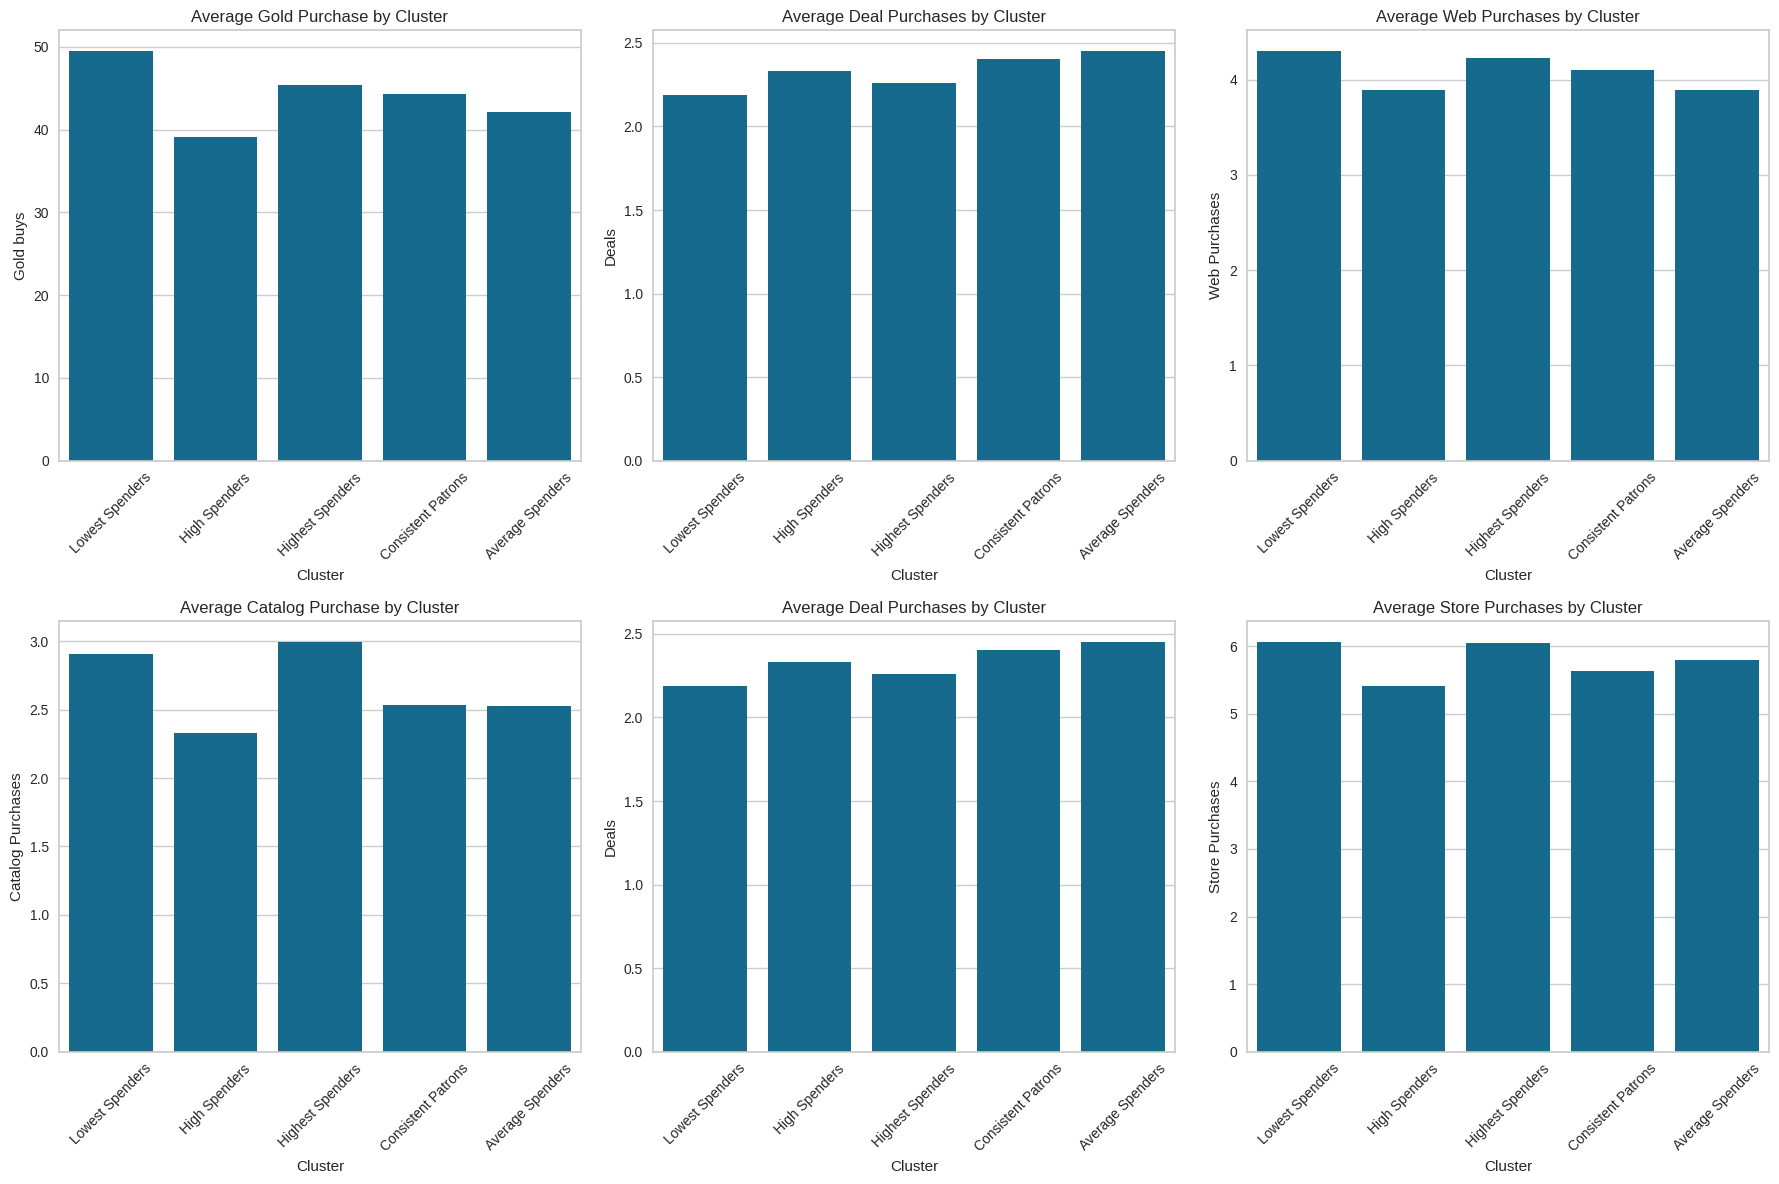

In [ ]:
### income, spending and tenure by clusters
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.barplot(x='cluster_labels', y='gold', data=customer_df_with_labels, ci=None)
plt.title('Average Gold Purchase by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Gold buys')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
sns.barplot(x='cluster_labels', y='deals', data=customer_df_with_labels, ci=None)
plt.title('Average Deal Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Deals')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
sns.barplot(x='cluster_labels', y='web', data=customer_df_with_labels, ci=None)
plt.title('Average Web Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Web Purchases')
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
sns.barplot(x='cluster_labels', y='catalog', data=customer_df_with_labels, ci=None)
plt.title('Average Catalog Purchase by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Catalog Purchases')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
sns.barplot(x='cluster_labels', y='deals', data=customer_df_with_labels, ci=None)
plt.title('Average Deal Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Deals')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
sns.barplot(x='cluster_labels', y='store', data=customer_df_with_labels, ci=None)
plt.title('Average Store Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Store Purchases')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

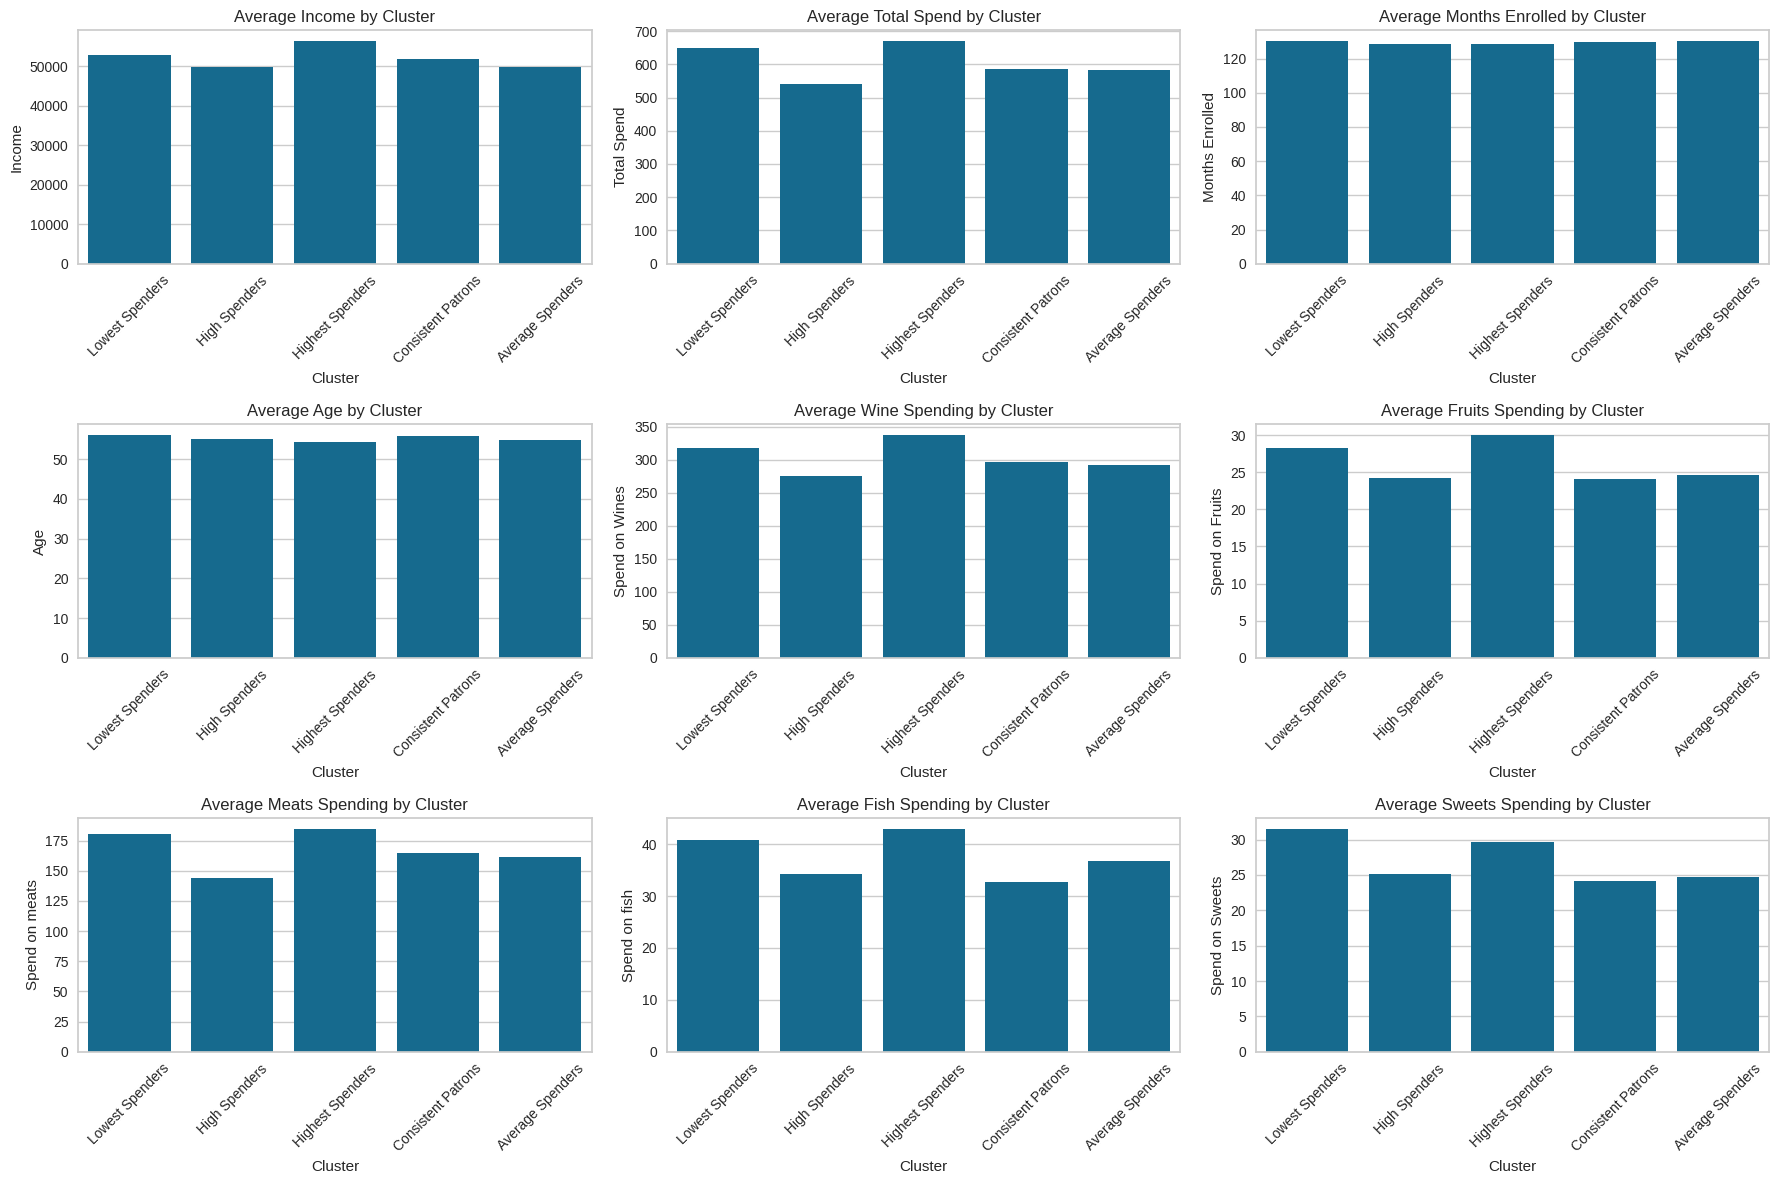

In [ ]:
### income, spending and tenure by clusters
plt.figure(figsize=(18, 12))

plt.subplot(3, 3, 1)
sns.barplot(x='cluster_labels', y='income', data=customer_df_with_labels, ci=None)
plt.title('Average Income by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.xticks(rotation=45)

plt.subplot(3, 3, 2)
sns.barplot(x='cluster_labels', y='total_spend', data=customer_df_with_labels, ci=None)
plt.title('Average Total Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)

plt.subplot(3, 3, 3)
sns.barplot(x='cluster_labels', y='months_enrolled', data=customer_df_with_labels, ci=None)
plt.title('Average Months Enrolled by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Months Enrolled')
plt.xticks(rotation=45)

plt.subplot(3, 3, 4)
sns.barplot(x='cluster_labels', y='age', data=customer_df_with_labels, ci=None)
plt.title('Average Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.xticks(rotation=45)

plt.subplot(3, 3, 5)
sns.barplot(x='cluster_labels', y='wines', data=customer_df_with_labels, ci=None)
plt.title('Average Wine Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend on Wines')
plt.xticks(rotation=45)

plt.subplot(3, 3, 6)
sns.barplot(x='cluster_labels', y='fruits', data=customer_df_with_labels, ci=None)
plt.title('Average Fruits Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend on Fruits')
plt.xticks(rotation=45)

plt.subplot(3, 3, 7)
sns.barplot(x='cluster_labels', y='meats', data=customer_df_with_labels, ci=None)
plt.title('Average Meats Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend on meats')
plt.xticks(rotation=45)

plt.subplot(3, 3, 8)
sns.barplot(x='cluster_labels', y='fish', data=customer_df_with_labels, ci=None)
plt.title('Average Fish Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend on fish')
plt.xticks(rotation=45)

plt.subplot(3, 3, 9)
sns.barplot(x='cluster_labels', y='sweets', data=customer_df_with_labels, ci=None)
plt.title('Average Sweets Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spend on Sweets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

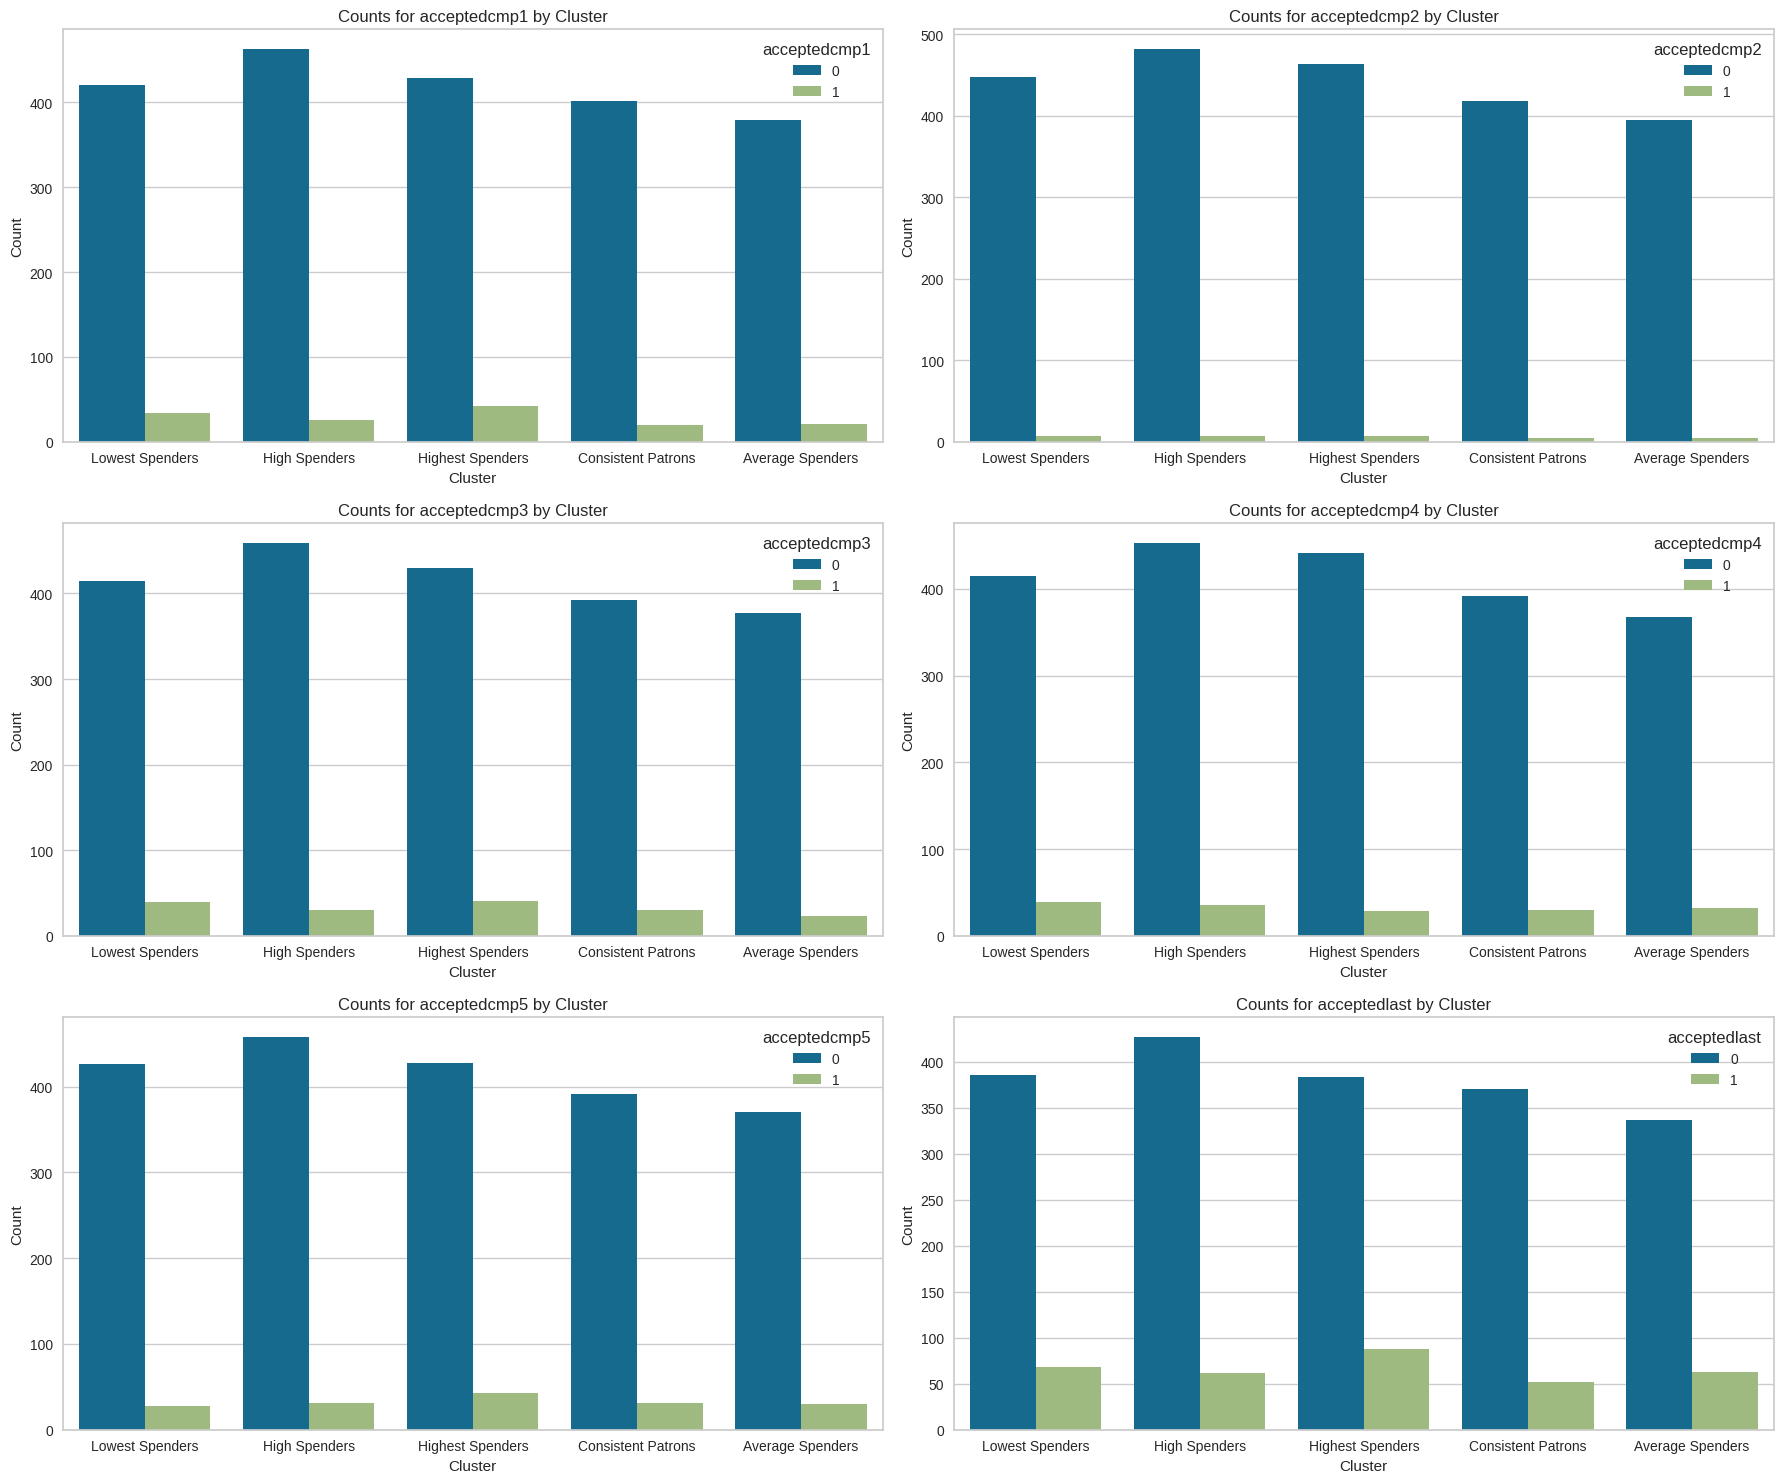

In [ ]:
plt.figure(figsize=(18, 15))

campaign_columns = ['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedlast']
for i, column in enumerate(campaign_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x='cluster_labels', hue=column, data=customer_df_with_labels)
    plt.title(f'Counts for {column} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=column, loc='upper right')

plt.tight_layout()
plt.show()


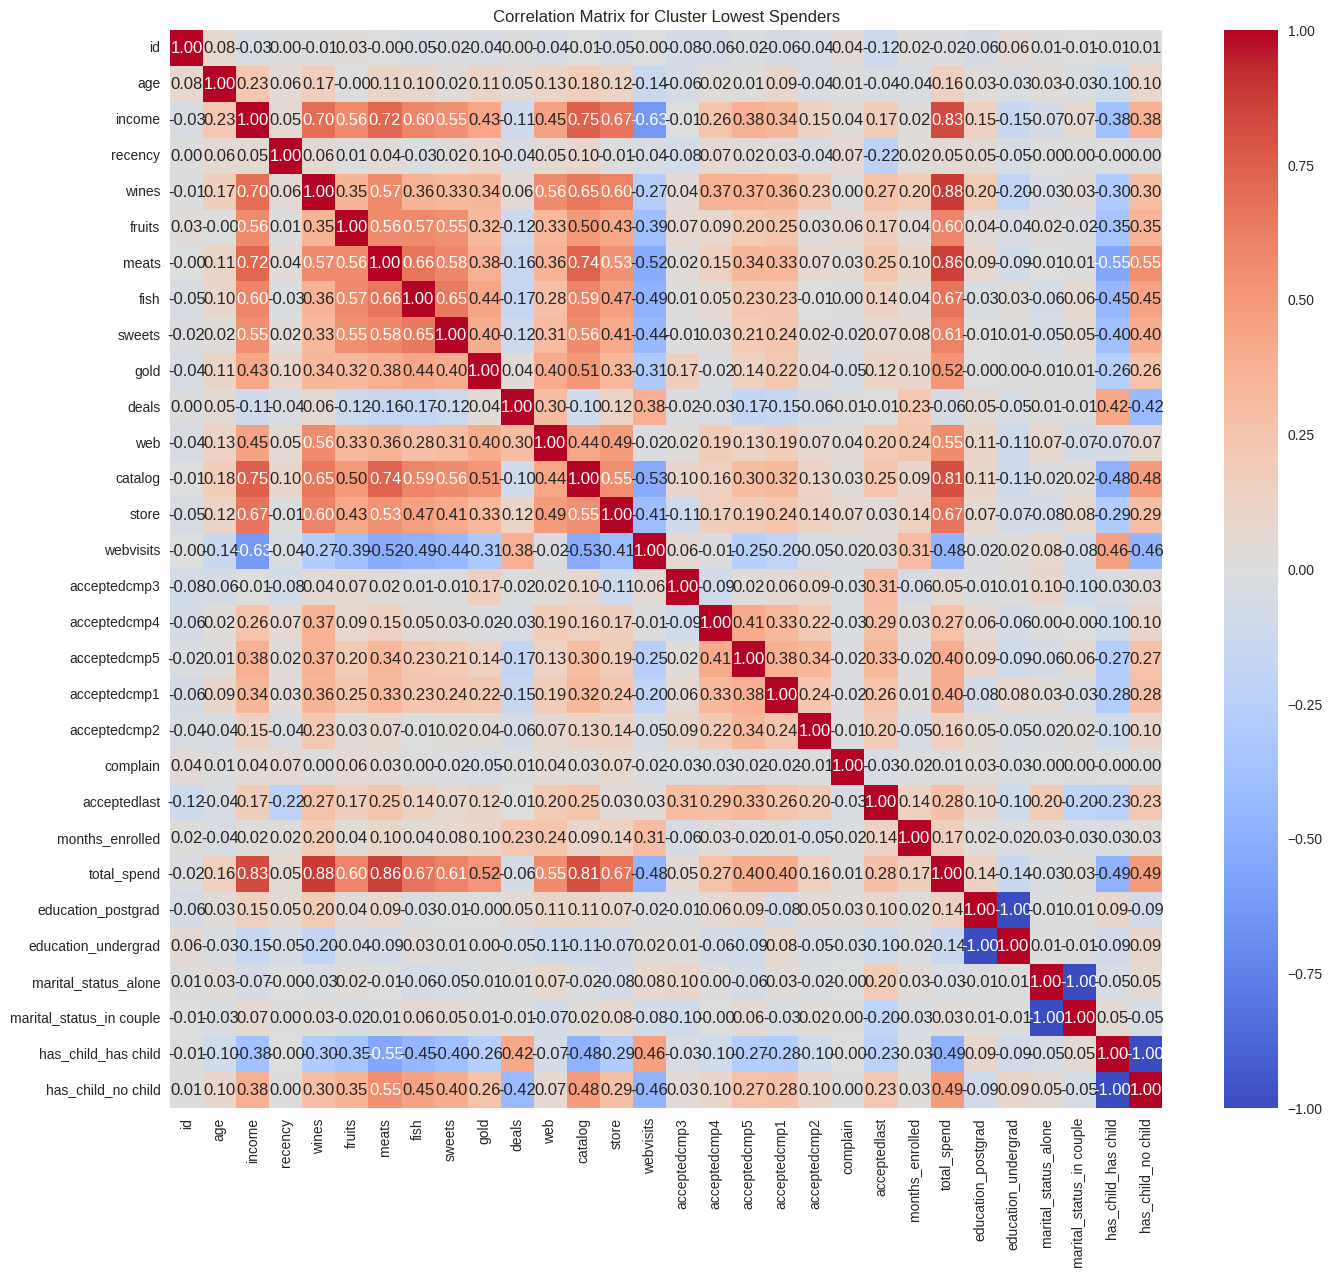

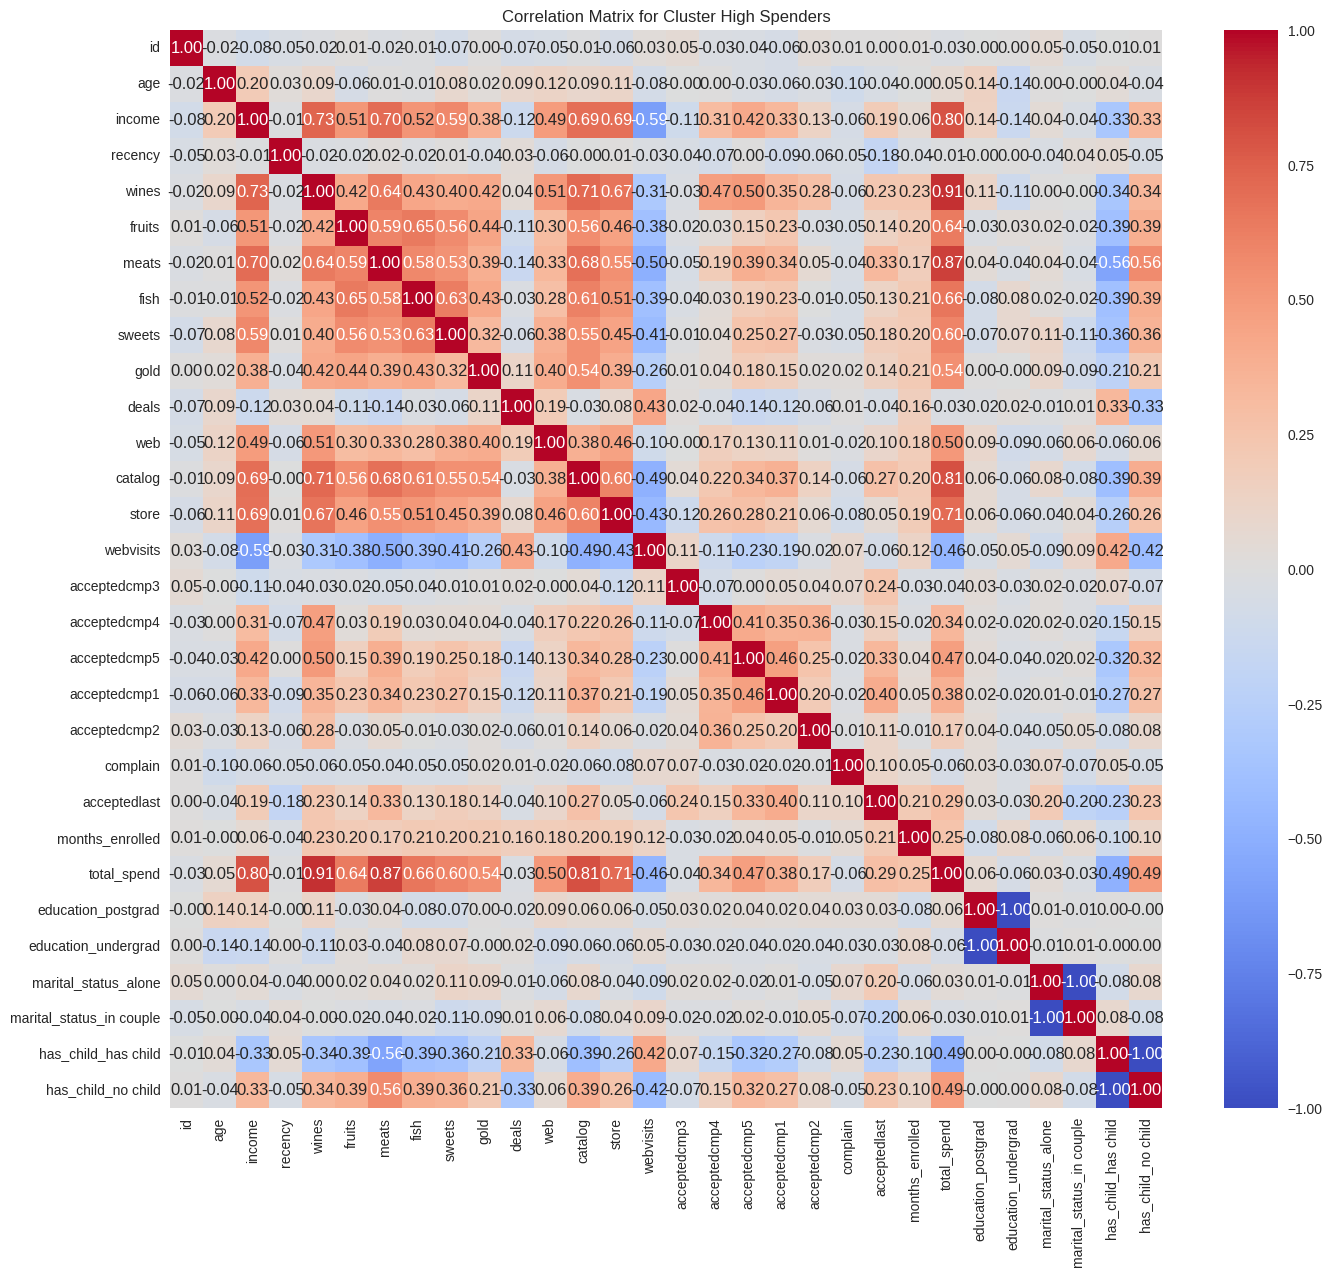

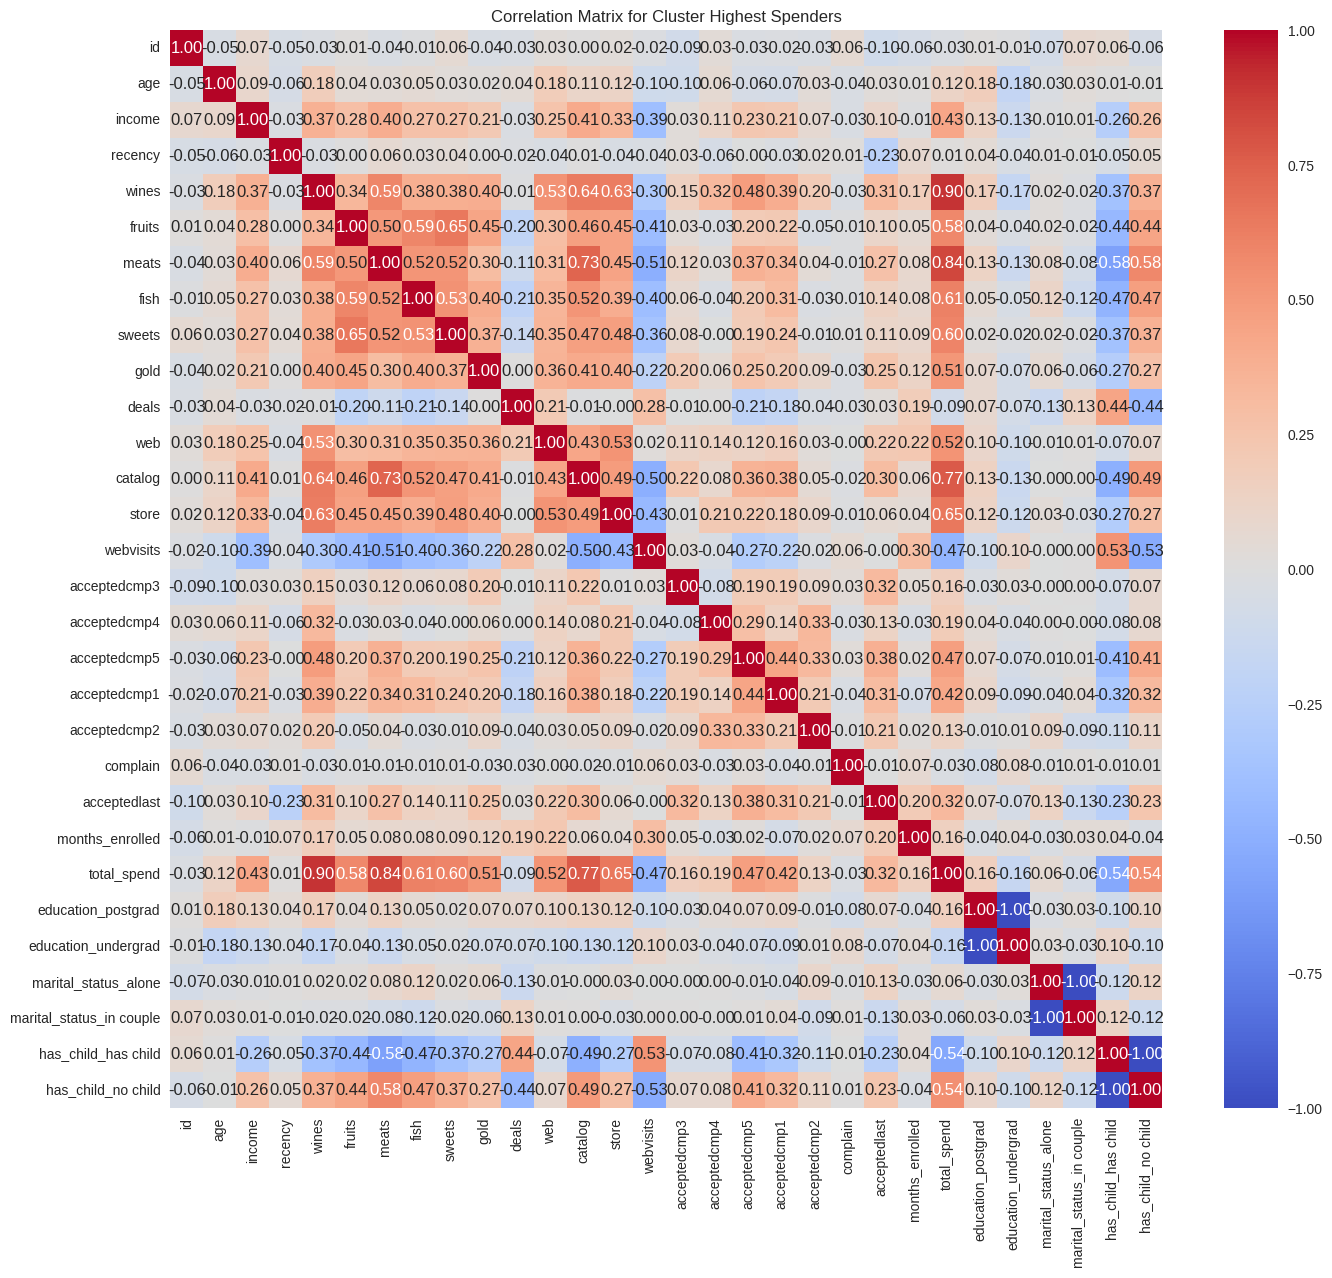

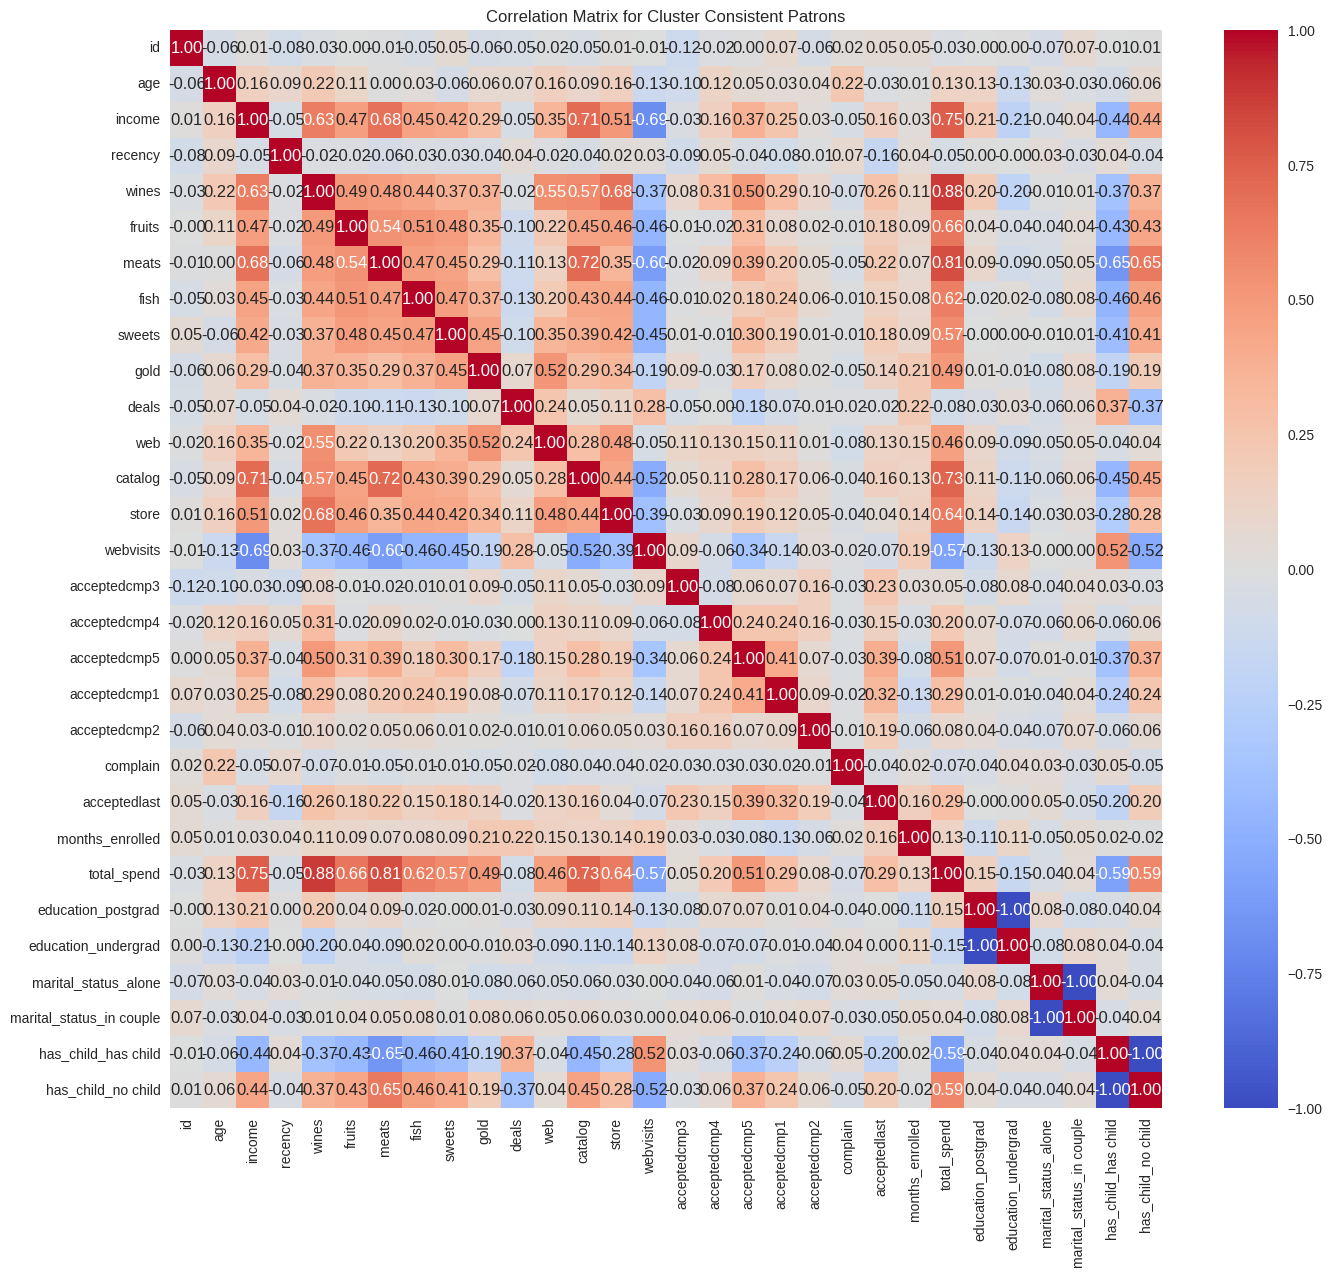

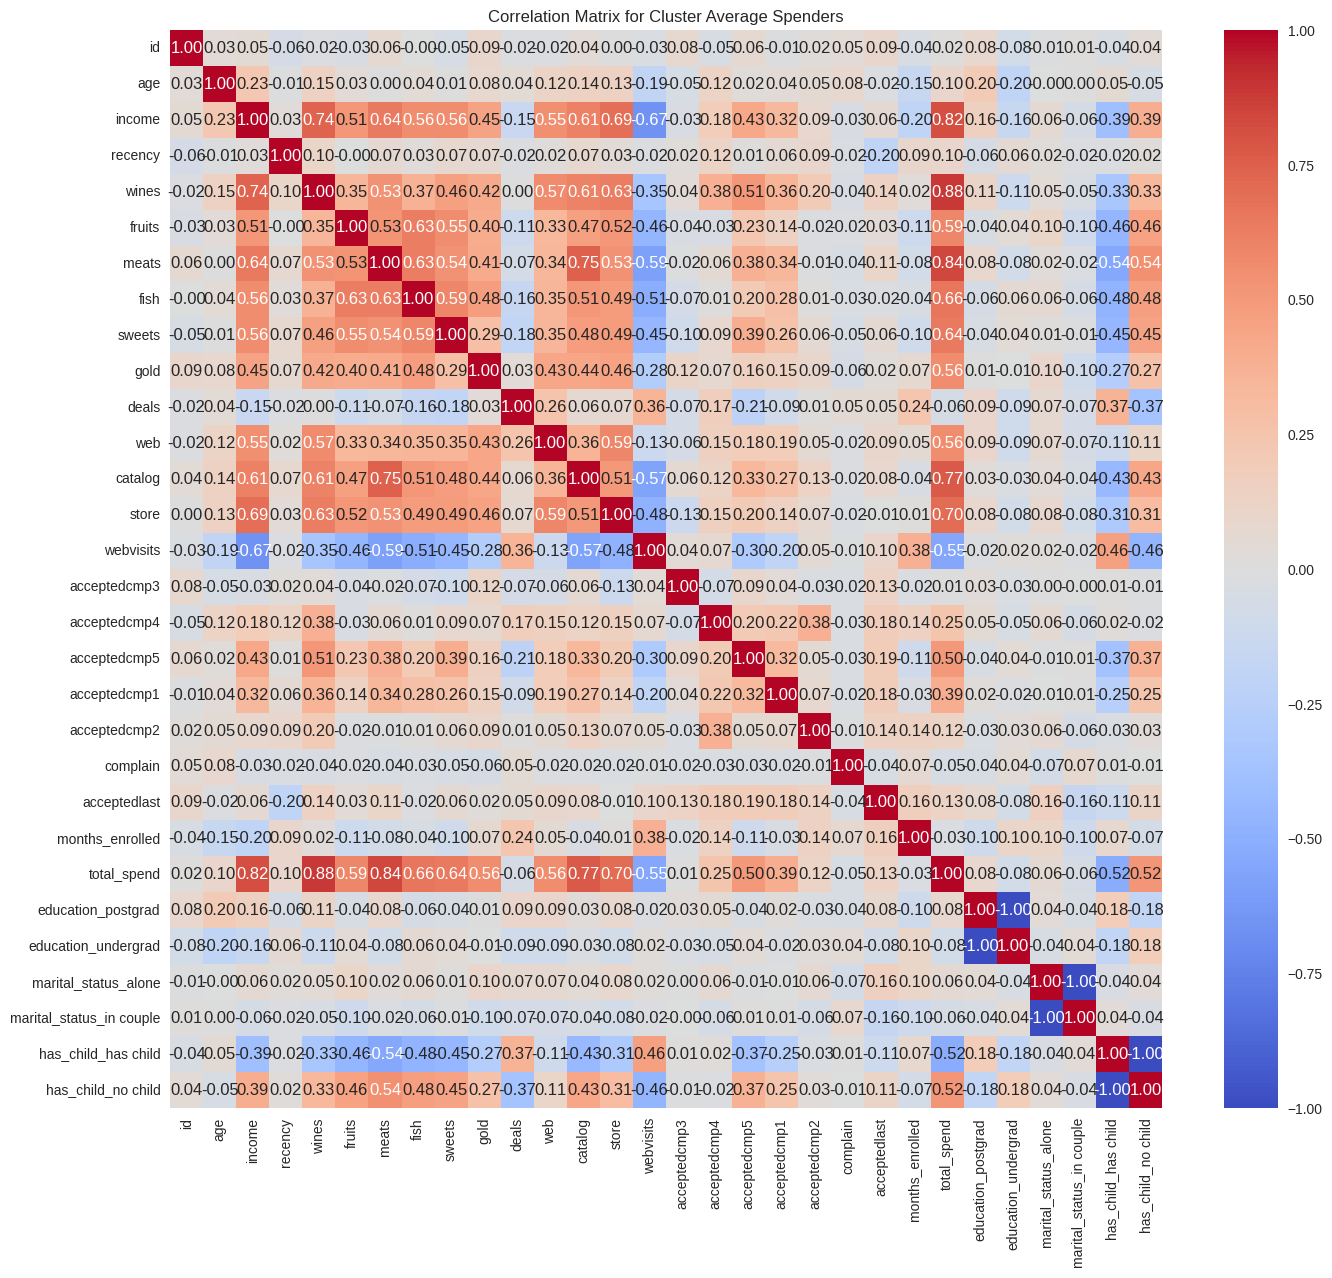

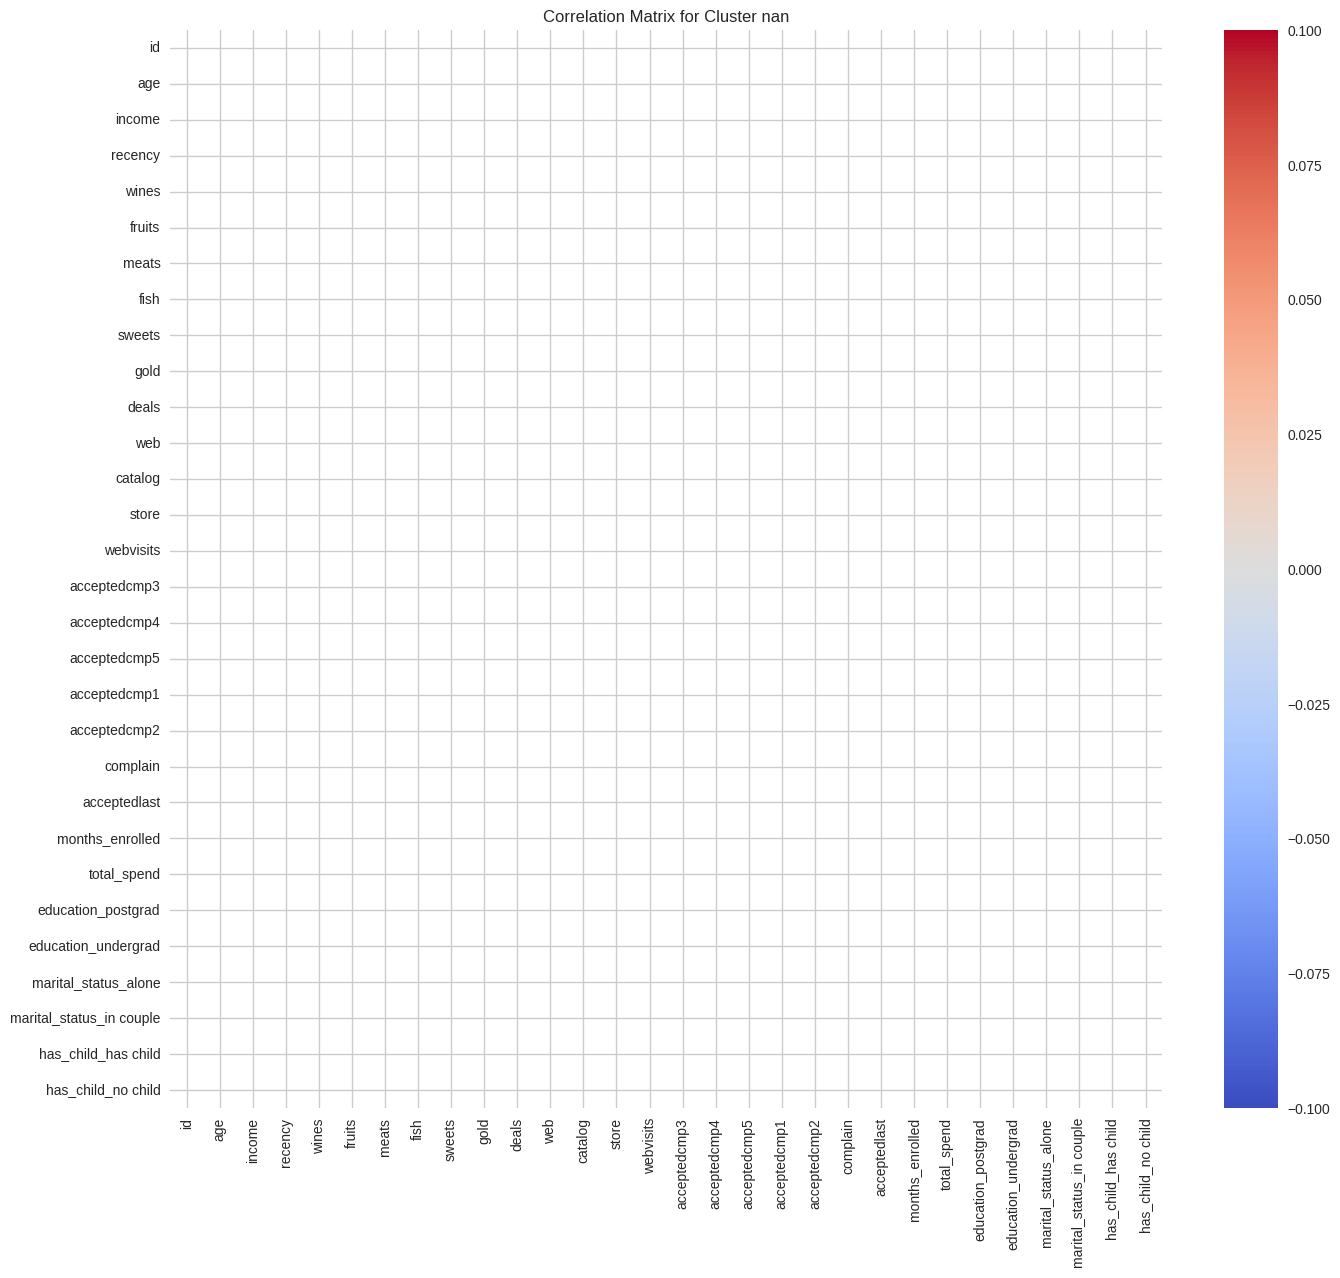

In [ ]:
for cluster_id in customer_df_with_labels['cluster_labels'].unique():
    cluster_data = customer_df_with_labels[customer_df_with_labels['cluster_labels'] == cluster_id]
    numeric_cols = cluster_data.select_dtypes(include=['number'])
    cleaned_data = numeric_cols.dropna()
    correlation_matrix = cleaned_data.corr()

    plt.figure(figsize=(16, 14))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(f'Correlation Matrix for Cluster {cluster_id}')
    plt.show()


# Discovering Buying Habits

In [ ]:
product_columns = ['wines', 'meats', 'fruits', 'gold', 'fish', 'sweets']
customer_df_with_labels[product_columns] = (customer_df_with_labels[product_columns] > 0).astype(int)

frequent_itemsets = apriori(customer_df_with_labels[product_columns], min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

print(f"Number of rules generated: {len(rules)}")
if not rules.empty:
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

    wine_rules = rules[rules['antecedents'].apply(lambda x: 'wines' in x)]
    if not wine_rules.empty:
        wine_rules = wine_rules.sort_values(by='confidence', ascending=False)
        top_10_rules = wine_rules.head(10)
        if not top_10_rules.empty:
            print("Top 10 Wine Association Rules:")
            print(top_10_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
        else:
            print("No top 10 wine rules to display.")
    else:
        print("No rules with 'wines' as an antecedent found.")
else:
    print("No rules generated with the current support and lift thresholds.")

###  about 99.42% of transactions containing wines also contains meats


Number of rules generated: 548
  antecedents consequents   support  confidence      lift
0     (meats)     (wines)  0.994196    0.994640  1.000447
1     (wines)     (meats)  0.994196    1.000000  1.000447
2    (fruits)     (wines)  0.817857    0.995652  1.001464
3     (wines)    (fruits)  0.817857    0.822631  1.001464
4    (fruits)     (meats)  0.821429    1.000000  1.000447
Top 10 Wine Association Rules:
                             antecedents consequents   support  confidence  \
1                                (wines)     (meats)  0.994196         1.0   
168                (gold, sweets, wines)     (meats)  0.792411         1.0   
310          (fruits, gold, fish, wines)     (meats)  0.719643         1.0   
117                (fruits, gold, wines)     (meats)  0.801786         1.0   
145              (fruits, sweets, wines)     (meats)  0.720982         1.0   
486  (fruits, fish, wines, gold, sweets)     (meats)  0.646875         1.0   
159                  (gold, fish, wines)    

In [ ]:
###  CONCLUSION

#    In conclusion, the cluster groups are clearly separated due to no overlap in income and spending and each of them has a little perk of its own.
#    High spenders spend the most gold and sweets purchases, more than the highest spenders.
#    Consistent Patrons and Average spenders lead in deals purchases and accepting campaigns in different stages.
#    99.4% of the time a customer that bought wine also bought meats, which confirms the positive correlation we found earlier.
#    The one weak point in the clustering is that on average the clusters have similar characteristics although on different scale in terms of spending.
#    All the custers show high correlation in income, spending, more catalogue and store purchases and product categories similarly.
#    Consistent patrons and Average spenders can be targeted for deals and campaigns due to higher acceptance rate.
#    High spenders and Highest spenders should be targeted for wine purchases, preferably with deal combinations with meats due to wine buyers also buying meats.
